# <center> Parallélisation en temps pour la résolution numérique d'équations différentielles </center>

## <center> Vuillemot Killian </center>

1. [Méthodes numériques principales](#1)
    1. [Méthodes associées au $\theta$-schéma](#1.1)
        1. [Euler explicite](#1.1.1)
        1. [Euler implicite](#1.1.2)
        1. [Crank-Nicolson](#1.1.3)
        1. [La $\theta$-méthode](#1.1.4)
    1. [Méthodes de Runge-Kutta](#1.2)
        1. [Méthode de Runge-Kutta d'ordre 2](#1.2.1)
        1. [Méthode de Runge-Kutta d'ordre 4](#1.2.2)
1. [Algorithme Pararéel](#2)
    1. [Algorithme séquentiel](#2.1)
    1. [Algorithme parallèle](#2.2)
1. [Quelques exemples et résultats](#3)
    1. [Les exemples unidimensionnels](#3.1)
        1. [La fonction exponentielle](#3.1.1)
        1. [La fonction sinus](#3.1.2)
    1. [Les exemples bidimensionnels](#3.2)
        1. [Les équations de Lotka-Volterra](#3.2.1)
        1. [Le Brusselator](#3.2.2)
    1. [Les exemples tridimensionnels](#3.3)
        1. [Les équations de Lorenz](#3.3.1)
        1. [Le système solaire externe](#3.3.2)
    1. [Exemples d'applications en biologie et en épidémiologie](#3.4)
    1. [Le $\theta$-schéma pour l'équation de la chaleur](#3.5)
1. [Bonus : quelques animations](#4)

Dans ce notebook, nous allons nous intéresser à la mise en place des différentes méthodes de résolution des équations différentielles ordinaires décrites dans le rapport. Pour cela, nous allons utiliser le langage Python. Ce Notebook sera décomposé en 3 parties principales ainsi qu'une partie animée. 

Tout d'abord, nous allons nous intéresser à l'implémentation des principales méthodes présentées dans le rapport. Nous ferons donc à chaque fois un rappel des formules utilisées pour ces méthodes.

Par la suite, nous implémenterons l'algorithme principal de ce projet : l'algorithme Pararéel. Nous verrons alors deux implémentations principales de l'algorithme Pararéel : une implémentation séquentielle puis une implémentation parallèle qui mettra en évidence l'intérêt de cet algorithme.

Enfin, nous verrons à travers plusieurs exemples  les différences entre les méthodes de résolution présentées ce qui nous permettra de visualiser certains points théoriques, puis les différences entre les deux implémentations de l'algorithme Pararéel. Pour cela, nous étudierons ces exemples en utilisant quelques-unes des méthodes présentées précédemment.

Finalement, nous verrons une implémentation du $\theta$-schéma dans le cadre des équations aux dérivées partielles, à travers l'équation de la chaleur, ce qui nous permettra de proposer un enrichissement à ce projet.


On importe tout d'abord les packages qui seront utiles pour la suite : **cellule à compiler deux fois**.

In [2]:
import numpy as np # module pour les calculs numériques
import matplotlib.pyplot as plt # module pour la gestion des affichages
from scipy.optimize import newton # on importe un module qui servira pour les méthodes implicites
from mpl_toolkits.mplot3d import Axes3D # Module pour faire les graphiques 3D
import matplotlib.colors as colors
from math import * # module pour les maths 
import time # utilisé pour mesurer les temps d'exécution
from joblib import Parallel, delayed # Pour la parallélisation
plt.style.use('fivethirtyeight') #style d'affichage
plt.rcParams['font.size'] = 10 #taille de police pour les graphiques
plt.rcParams['figure.figsize']=(9,7) # taille des figures
plt.rcParams['legend.shadow']=True # fond pour la box des légendes
plt.rcParams['lines.linewidth']=1.5 #épaisseur des tracés
plt.rcParams['patch.edgecolor']='black' #couleur
import warnings # package pour les warnings
warnings.filterwarnings('ignore') # on cache les warnings 
import os 
from IPython.display import HTML # pour afficher les vidéos
%matplotlib notebook 

# Méthodes numériques principales <a name="1"></a>

Nous allons tout d'abord introduire certaines méthodes de résolution numérique. Tout d'abord, on implémente les méthodes numériques associées au $\theta $-schéma : les méthodes d'Euler, la méthode de Crank-Nicolson puis le $\theta$-schéma général.

## Méthodes associées au $\theta$-schéma<a name="1.1"></a>

###  Euler explicite <a name="1.1.1"></a>

On définit la méthode d'Euler explicite comme suit :
$$\begin{cases}  y_{i+1} = y_i + \Delta t f(y_i,t_i) \\ y_0 = y(t_0). \end{cases} $$

In [3]:
def EulerExplicite(f,t0,tf,y0,n) : 
    # f = fonction de Y , t
    # t0 = temps initial 
    # tf = temps final 
    # y0 = condition initiale 
    # n = entier (découpage de l'intervalle [t0,tf] en n segments)
    # return : les n+1 temps ti et les valeurs approchées de y à chaque ti
    dt=(tf-t0)/n # calcul du pas de temps 
    T=[t0+i*dt for i in range(n+1)] # création de l'intervalle de temps
    Y=[y0] # initialisation du vecteur des solutions
    for i in range(n) : 
        Y.append(Y[-1]+dt*f(Y[-1],T[i])) # calcul de la solution 
    return(T,Y)

###  Euler implicite <a name="1.1.2"></a>

La méthode repose sur la formule : 
$$ \begin{cases} y_{i+1}= y_{i} + \Delta t  f(y_{i+1},t_{i+1}) \\y_0=y(t_0). \end{cases} $$

In [4]:
def EulerImplicite(f, t0,tf,y0, n):
    # f = fonction de Y , t
    # t0 = temps initial 
    # tf = temps final 
    # y0 = condition initiale 
    # n = entier (découpage de l'intervalle [t0,tf] en n segments)
    # return : les n+1 temps ti et les valeurs approchées de y à chaque ti
    Y = [y0]
    dt= (tf-t0)/n
    T=[t0+i*dt for i in range(n+1)]
    for i in range(n):
        res=newton(lambda y: Y[i]+dt*f(y,T[i+1])-y,Y[i])
        Y.append(res)
    return (T,Y)

### Crank-Nicolson <a name="1.1.3"></a>

La méthode suivante repose sur la relation : 
$$\begin{cases}  y_{i+1} = y_i + \frac{\Delta t}{2} \left( f(y_i,t_i)+f(y_{i+1},t_{i+1} )\right) \\ y_0 = y(t_0). \end{cases} $$

In [5]:
def CrankNicolson(f, t0,tf,y0, n) :
    # f = fonction de Y , t
    # t0 = temps initial 
    # tf = temps final 
    # y0 = condition initiale 
    # n = entier (découpage de l'intervalle [t0,tf] en n segments)
    # return : les n+1 temps ti et les valeurs approchées de y à chaque ti
    dt=(tf-t0)/n # calcul du pas de temps 
    T=[t0+i*dt for i in range(n+1)] # création de l'intervalle de temps
    Y=[y0] # initialisation du vecteur des solutions
    for i in range(n) : 
        impl = newton(lambda y: Y[i]+dt*f(y,T[i+1])-y,Y[i])
        expl=Y[-1]+dt*f(Y[-1],T[i])
        Y.append((1/2)*(impl+expl))
    return(T,Y)

### La $\theta$-méthode <a name="1.1.4"></a>

On définit alors maintenant la $\theta$-méthode, en se basant sur la formule : 
$$\begin{cases}  y_{i+1} = y_i + \Delta t \left( (1-\theta) f(y_i,t_i)+ \theta f(y_{i+1},t_{i+1}) \right) \\ y_0 = y(t_0). \end{cases} $$
Il est alors nécessaire d'ajouter un paramètre dans la méthode : en effet, il faut ajouter le paramètre $\theta$ à utiliser.

In [6]:
def thetamethode(f, t0,tf,y0, n,theta) :
    # f = fonction de Y , t
    # t0 = temps initial 
    # tf = temps final 
    # y0 = condition initiale 
    # n = entier (découpage de l'intervalle [t0,tf] en n segments)
    # return : les n+1 temps ti et les valeurs approchées de y à chaque ti
    dt=(tf-t0)/n # calcul du pas de temps 
    T=[t0+i*dt for i in range(n+1)] # création de l'intervalle de temps
    Y=[y0] # initialisation du vecteur des solutions
    for i in range(n) : 
        impl = newton(lambda y: Y[i]+dt*f(y,T[i+1])-y,Y[i])
        expl=Y[-1]+dt*f(Y[-1],T[i])
        Y.append(theta*impl+(1-theta)*expl)
    return(T,Y)

## Méthodes de Runge-Kutta  <a name="1.2"></a>

### Méthode de Runge-Kutta d'ordre 2  <a name="1.2.1"></a>

La méthode de Runge-Kutta d'ordre 2 (ou méthode de Heun) repose sur la formule suivante :
$$ \begin{cases}
y_{i+1} = y_i + \Delta t\left(\frac{1}{2} k_1 + \frac{1}{2} k_2 \right) \\
y_0=y(t_0)
\end{cases}  \text{ avec } \begin{cases}
k_1 = f(y_i, t_i) \\ k_2 = f(y_i +\Delta t k_1,t_i+\Delta t ) .
\end{cases} $$

In [7]:
def RK2(f,t0,tf,y0,n) : 
    # f = fonction de Y , t
    # t0 = temps initial 
    # tf = temps final 
    # y0 = condition initiale 
    # n = entier (découpage de l'intervalle [t0,tf] en n segments)
    # return : les n+1 temps ti et les valeurs approchées de y à chaque ti
    h=(tf-t0)/n
    t=t0
    y=y0
    T=[t]
    Y=[y]
    for i in range(n) :
        k1=f(y,t)
        k2=f(y+h*k1,t+h)
        y=y+(h/2)*(k1+k2) 
        t=t+h
        T.append(t)
        Y.append(y)
    return(T,Y)

### Méthode de Runge-Kutta d'ordre 4  <a name="1.2.2"></a>

Pour cette méthode, on a besoin de définir 4 coefficients à chaque itération :
\begin{align*}
k_1 &= f(y_i,t_i), \\
k_2 &= f(y_i + \frac{\Delta t}{2} k_1 , t_i + \frac{\Delta t}{2} ), \\ 
k_3 &= f(y_i + \frac{\Delta t}{2} k_2 , t_i + \frac{\Delta t}{2}), \\
k_4 &= f(y_i + \Delta t k_3 , t_i + \Delta t).
\end{align*} 
On a ensuite la formule :
$$ \begin{cases} y_{i+1}= y_{i} + \frac{\Delta t}{6} (k_1+2k_2+2k_3+k_4) \\ y_0=y(t_0). \end{cases} $$

In [8]:
def RK4(f,t0,tf,y0,n) : 
    # f = fonction de Y , t
    # t0 = temps initial 
    # tf = temps final 
    # y0 = condition initiale 
    # n = entier (découpage de l'intervalle [t0,tf] en n segments)
    # return : les n+1 temps ti et les valeurs approchées de y à chaque ti
    h=(tf-t0)/n
    t=t0
    y=y0
    T=[t]
    Y=[y]
    for i in range(n) :
        k1=f(y,t)
        k2=f(y+(h/2)*k1,t+h/2)
        k3=f(y+(h/2)*k2,t+h/2)
        k4=f(y+h*k3,t+h)
        y=y+(h/6)*(k1+2*k2+2*k3+k4) 
        t=t+h
        T.append(t)
        Y.append(y)
    return(T,Y)

# Algorithme Pararéel <a name="2"></a>

## Algorithme séquentiel <a name="2.1"></a>

Tout d'abord, on choisit d'implémenter l'algorithme Pararéel de façon séquentielle. On fait donc ici travailler l'algorithme sur un seul processeur. On applique la méthode fine choisie de façon séquentielle : on utilise une boucle `for` qui permettra de parcourir tout l'intervalle de temps et on fait les calculs un par un, à la suite.

In [9]:
def parareal_seq(func,Fin,NF,Grossier,NG,T,y0,K) :
    # func : fonction sur laquelle on applique l'algorithme
    # Fin : méthode fine utilisée (ex : Runge)
    # NF : nombre de sous-intervalles pour chaque sous-intervalle [T_i, T_{i+1}]
    # Grossier : méthode grossière utilisée
    # NG : nombre de sous-intervalles de l'intervalle [0,T]
    # T : temps final 
    # y0 : condition initiale au temps 0
    # K : nombre d'itérations de l'algorithme
    
    def F(t0,t1,y0): # on définit F qui sera la méthode fine
        return Fin(func,t0,t1,y0,NF)[1] # on retourne la solution calculée par la méthode fine
    def G(t0,t1,y0): # de même pour la méthode fine
        return Grossier(func,t0,t1,y0,1)[1]
    
    TT=np.linspace(0,T,NG+1) # initialisation de l'espace temps grossier    
    starts=np.linspace(TT[0],TT[-2],len(TT)-1) #on crée la liste des temps initiaux de chaque sous-intervalle
    ends=np.linspace(TT[1],TT[-1],len(TT)-1) # on crée la liste des temps finaux de chaque sous-intervalle
    tt=np.linspace(start=starts,stop=ends,num=NF+1).T   # on combine le tout et on a une "matrice" de temps
    tt=np.concatenate(tt[:],axis=0) # on concatène les lignes de l'espace temps et on a l'espace final
    Gn=np.zeros((K+1,NG+1,len(y0))) # on crée la matrice des approximations grossières à chaque itération
    FN=np.zeros((K,(NG*(NF+1)),len(y0))) # on crée la matrice des approximations fines à chaque itération
    Fn=np.zeros((K,NG,NF+1,len(y0))) # matrice des approximations fines sur chaque sous-intervalle à chaque itération
    GN=np.zeros((NG+1,len(y0))) # matrices "temporaaires" qui permettent une unique application  
    G0=np.zeros((NG+1,len(y0))) # de la méthode grossière par itération
    Gn[0,0]=y0 #initialisation de la condition initiale
    for n in range(NG): # on initialise avec la méthode fine
        Gn[0,n+1,:]=G(TT[n],TT[n+1],Gn[0,n])[-1]
        G0[n]=Gn[0,n+1]
    for k in range(K): #on itère 
        for n in range(NG) : # calcul en séquentiel
            Fn[k,n]=F(TT[n],TT[n+1],Gn[k,n]) # méthode fine sur chaque sous-intervalle                         
        Gn[k+1,0]=y0 # condition initiale pour l'itération
        
        for n in range(NG) : # on parcourt tous les sous-intervalles
            GN[n]=G(TT[n],TT[n+1],Gn[k+1,n])[-1]
            Gn[k+1,n+1]=Fn[k,n,-1]+GN[n]-G0[n]
        G0[:]=GN[:]
        FN[k,:]=np.concatenate(Fn[k,:],axis=0) # on concatène pour obtenir finalement un unique vecteur par itération
    return(tt,Fn,Gn,FN) # on retourne 4 tableaux : l'espace-temps, les approximations fines séparées en sous-intervalles,
                        # les approximation grossières à chaque itération et la solution fine à chaque itération 

**Remarque : ici, on implémente l'algorithme avec un nombre maximal d'itérations. Cependant, on pourrait également ajouter un critère d'arrêt sur la norme de la différence entre deux itérations consécutives de l'algorithme.**

## Algorithme parallèle <a name="2.2"></a>

Une fois la première implémentation réalisée, on va chercher à paralléliser cet algorithme. C'est à ce moment que la dénomination d'algorithme "Pararéel" prend tout son sens. On applique en effet le solveur fin en parallèle sur les différents processeurs. On utilise pour cela le package `joblib` qui va nous permettre de séparer les tâches et de les attribuer aux différents processeurs. 

On modifie alors la boucle `for` de la méthode séquentielle en une ligne où l'on précise le nombre de processeurs à utiliser : `n_jobs = p` (en choisissant `-1`, tous les processeurs seront utilisés). On indique alors la fonction à appliquer en parallèle, en l'occurence la méthode fine que l'on applique sur chaque sous-intervalle de temps.

In [10]:
def parareal(func,Fin,NF,Grossier,NG,T,y0,K,p=-1) :
    # func : fonction sur laquelle on applique l'algorithme
    # Fin : méthode fine utilisée (ex : Runge)
    # NF : nombre de sous-intervalles pour chaque sous-intervalle [T_i, T_{i+1}]
    # Grossier : méthode grossière utilisée
    # NG : nombre de sous-intervalles de l'intervalle [0,T]
    # T : temps final 
    # y0 : condition initiale au temps 0
    # K : nombre d'itérations de l'algorithme
    # p : nombre de processeurs à utiliser (par défaut -1 : tous les processeurs sont utilisés)
    def F(t0,t1,y0): # on définit F qui sera la méthode fine
        return Fin(func,t0,t1,y0,NF)[1] # on retourne la solution calculée par la fine
    def G(t0,t1,y0): # de même pour la méthode fine
        return Grossier(func,t0,t1,y0,1)[1]
    
    TT=np.linspace(0,T,NG+1) # initialisation de l'espace temps grossier
    starts=np.linspace(TT[0],TT[-2],len(TT)-1) #on crée la liste des temps initiaux de chaque sous-intervalle
    ends=np.linspace(TT[1],TT[-1],len(TT)-1) # on crée la liste des temps finaux de chaque sous-intervalle
    tt=np.linspace(start=starts,stop=ends,num=NF+1).T   # on combine le tout et on a une "matrice" de temps
    tt=np.concatenate(tt[:],axis=0) # on concatène les lignes de l'espace temps et on a l'espace final
    Gn=np.zeros((K+1,NG+1,len(y0))) # on crée la matrice des approximations grossières à chaque itération
    FN=np.zeros((K,(NG*(NF+1)),len(y0))) # on crée la matrice des approximations fines à chaque itération
    Fn=np.zeros((K,NG,NF+1,len(y0))) # matrice des approximations fines sur chaque sous-intervalle à chaque itération
    GN=np.zeros((NG+1,len(y0))) # matrices "temporaaires" qui permettent une unique application  
    G0=np.zeros((NG+1,len(y0))) # de la méthode grossière par itération
    Gn[0,0]=y0 #initialisation de la condition initiale
    for n in range(NG): # on initialise avec la méthode fine
        Gn[0,n+1,:]=G(TT[n],TT[n+1],Gn[0,n])[-1]
        G0[n]=Gn[0,n+1]
    
    for k in range(K): #on itère 
        Fn[k,:]=Parallel(n_jobs=p)(delayed(F)(TT[n],TT[n+1],Gn[k,n]) for n in range(NG)) # calcul en parallèle
                                                                    # méthode fine sur chaque sous-intervalle
        Gn[k+1,0]=y0 # condition initiale pour l'itération
        for n in range(NG) : # on parcourt tous les sous-intervalles
            GN[n]=G(TT[n],TT[n+1],Gn[k+1,n])[-1]
            Gn[k+1,n+1]=Fn[k,n,-1]+GN[n]-G0[n]
        G0[:]=GN[:]
        FN[k,:]=np.concatenate(Fn[k,:],axis=0) # on concatène pour obtenir finalement un unique vecteur par itération
    return(tt,Fn,Gn,FN) # on retourne 4 tableaux : l'espace-temps, les approximations fines séparées en sous-intervalles,
                        # les approximation grossières à chaque itération et la solution fine à chaque itération 

**Remarque : l'inconvénient de cet algorithme est qu'il ets très gourmant en mémoire. On propose donc une seconde version, un peu moins gourmande mais moins optimale en termes de temps. La différence en temps sera ici très faible vu le faible nombre de points grossiers utilisés. Cependant sur des exemples utilisant un très grand nombre de points grossiers ou ou méthode grossière d'ordre plus élevé que 1, la différence deviendrait plus importante.**

**Ici, étant donné les exemples considérés, on pourra utiliser la version la plus otpimisée sans risques de surcharge mémoire.**

In [11]:
def parareal_bis(func,Fin,NF,Grossier,NG,T,y0,K,p=-1) :
    # func : fonction sur laquelle on applique l'algorithme
    # Fin : méthode fine utilisée (ex : Runge)
    # NF : nombre de sous-intervalles pour chaque sous-intervalle [T_i, T_{i+1}]
    # Grossier : méthode grossière utilisée
    # NG : nombre de sous-intervalles de l'intervalle [0,T]
    # T : temps final 
    # y0 : condition initiale au temps 0
    # K : nombre d'itérations de l'algorithme
    # p : nombre de processeurs à utiliser (par défaut -1 : tous les processeurs sont utilisés)
    def F(t0,t1,y0): # on définit F qui sera la méthode fine
        return Fin(func,t0,t1,y0,NF)[1] # on retourne la solution calculée par la fine
    def G(t0,t1,y0): # de même pour la méthode fine
        return Grossier(func,t0,t1,y0,1)[1]
    
    TT=np.linspace(0,T,NG+1) # initialisation de l'espace temps grossier
    starts=np.linspace(TT[0],TT[-2],len(TT)-1) #on crée la liste des temps initiaux de chaque sous-intervalle
    ends=np.linspace(TT[1],TT[-1],len(TT)-1) # on crée la liste des temps finaux de chaque sous-intervalle
    tt=np.linspace(start=starts,stop=ends,num=NF+1).T   # on combine le tout et on a une "matrice" de temps
    tt=np.concatenate(tt[:],axis=0) # on concatène les lignes de l'espace temps et on a l'espace final
    Gn=np.zeros((K+1,NG+1,len(y0))) # on crée la matrice des approximations grossières à chaque itération
    FN=np.zeros((K,(NG*(NF+1)),len(y0))) # on crée la matrice des approximations fines à chaque itération
    Fn=np.zeros((K,NG,NF+1,len(y0))) # matrice des approximations fines sur chaque sous-intervalle à chaque itération
    Gn[0,0]=y0
    for n in range(NG):
        Gn[0,n+1,:]=G(TT[n],TT[n+1],Gn[0,n])[-1]
    
    for k in range(K): #on itère 
        Fn[k,:]=Parallel(n_jobs=p)(delayed(F)(TT[n],TT[n+1],Gn[k,n]) for n in range(NG)) # calcul en parallèle
                                                                    # méthode fine sur chaque sous-intervalle
        Gn[k+1,0]=y0 # condition initiale pour l'itération
        for n in range(NG) : # on parcourt tous les sous-intervalles
            Gn[k+1,n+1]=Fn[k,n,-1]+G(TT[n],TT[n+1],Gn[k+1,n])[-1]-G(TT[n],TT[n+1],Gn[k,n])[-1]
        FN[k,:]=np.concatenate(Fn[k,:],axis=0) # on concatène pour obtenir finalement un unique vecteur par itération
    return(tt,Fn,Gn,FN) # on retourne 4 tableaux : l'espace-temps, les approximations fines séparées en sous-intervalles,
                        # les approximation grossières à chaque itération et la solution fine à chaque itération 

# Quelques exemples et résultats  <a name="3"></a>

Nous allons tout d'abord chercher à visualiser les résultats obtenus avec les méthodes numériques simples, à travers des exemples simples. 

## Exemples unidimensionnels <a name="3.1"></a>

On commence avec des exemples unidimensionnels. Pour cela, on prend deux équations différentielles de solutions exactes $\exp(t)$ et $\sin(t)$.

### La fonction exponentielle <a name="3.1.1"></a>

On prend ici l'exemple de la fontion exponentielle. Pour cela, on pose l'équation différentielle suivante : $$ \begin{cases} \dot{y}(t) = y(t)  \\ y(0) = 1. \end{cases} $$ 
On obtient alors la solution : $$ y(t) = \exp(t). $$

In [12]:
def fexp(Y,t) :
    return(Y)

On représente alors les résultats obtenus avec les différentes méhodes de résolution. On prend pour cela un intervalle de temps $[0,3]$ et on prend une discrétisation avec $2001$ points.

<IPython.core.display.Javascript object>


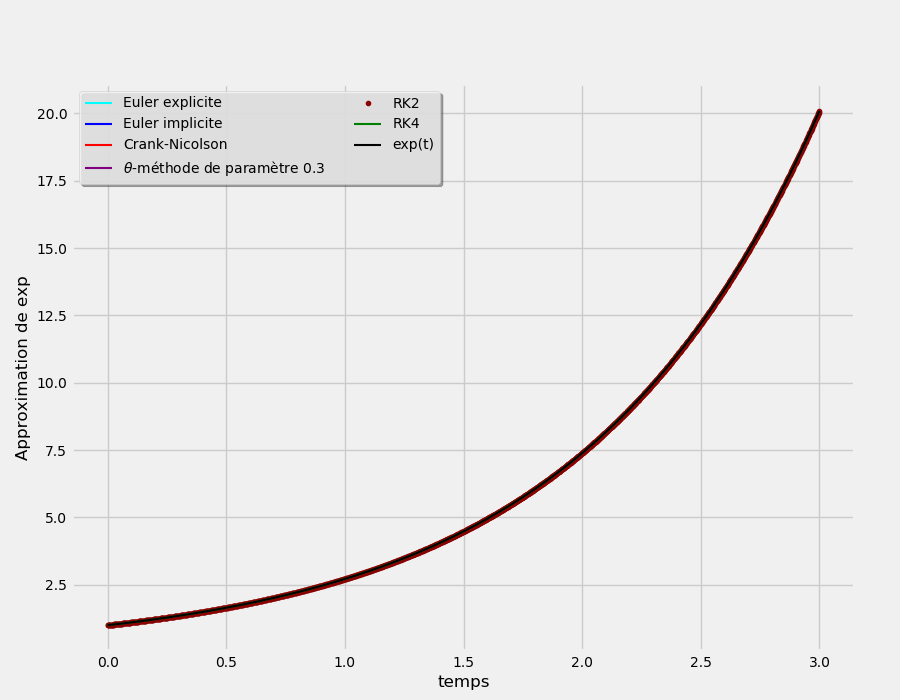

In [13]:
t0,tf,y0,n=0,3,1,2000
plt.figure()
temps,euler_explicite=EulerExplicite(fexp,t0,tf,y0,n)
euler_implicite=EulerImplicite(fexp,t0,tf,y0,n)[1]
rk2=RK2(fexp,t0,tf,y0,n)[1]
rk4=RK4(fexp,t0,tf,y0,n)[1]
CN=CrankNicolson(fexp,t0,tf,y0,n)[1]
theta_methode=thetamethode(fexp,t0,tf,y0,n,0.3)[1]

plt.plot(temps,euler_explicite,color='cyan',label="Euler explicite")
plt.plot(temps,euler_implicite,color='blue',label="Euler implicite")
plt.plot(temps,CN,color='red',label="Crank-Nicolson")
plt.plot(temps,theta_methode,color='purple',label=r'$\theta$-méthode de paramètre 0.3')
plt.plot(temps,rk2,'.',color='darkred',label="RK2")
plt.plot(temps,rk4,color='green',label="RK4")
plt.plot(temps,np.exp(temps),color='black',label="exp(t)")

plt.ylabel("Approximation de exp")
plt.xlabel("temps")
plt.legend(ncol=2)
plt.show()

On voit que toutes les solutions semblent confondues. On ne peut donc pas comparer ces méthodes seulement à l'aide de ce graphique.

On représente alors l'erreur de chacune des méthodes : on voit bien que pour les méthodes d'Euler, l'erreur croît en fonction du temps alors que pour les deux autres méthodes l'erreur est extrêment faible. Pour mieux visualiser cela, on se propose de représenter la différence entre chaque méthode et la valeur de l'exponentielle sur l'intervalle étudié. On voit qu'au fil des itérations des méthodes d'Euler, l'erreur augmente de façon exponentielle (sur cet exemple) quand les autres erreurs restent très proches de 0.

<IPython.core.display.Javascript object>


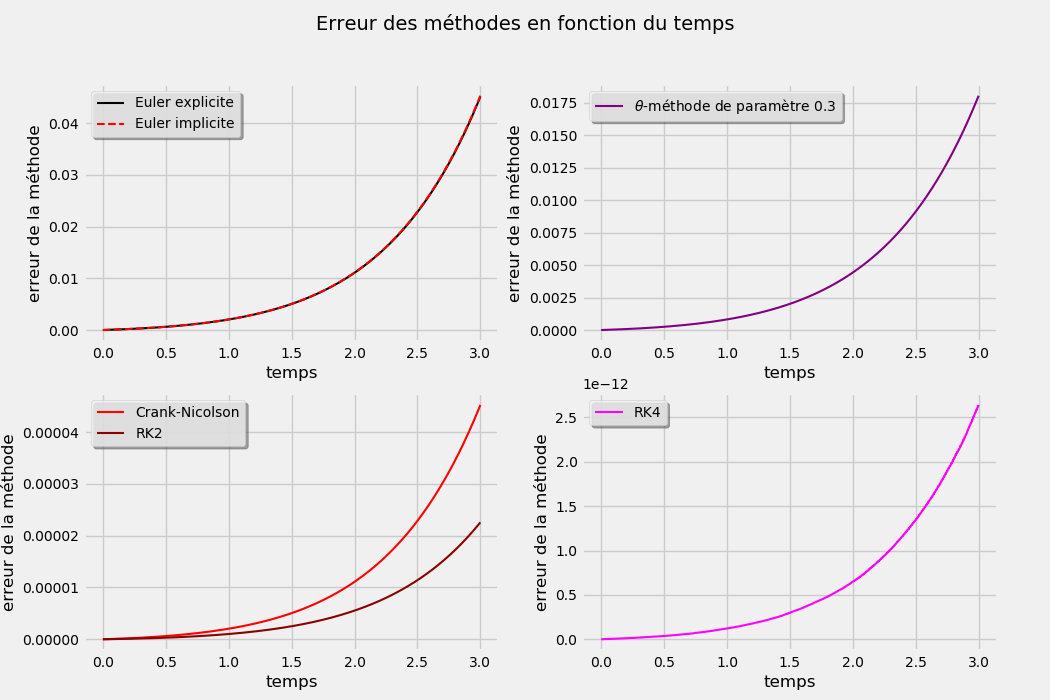

In [14]:
plt.figure(figsize=(10.5,7))
plt.subplot(221)
plt.plot(temps,abs(euler_explicite-np.exp(temps)),color='black',label="Euler explicite")
plt.plot(temps,abs(euler_implicite-np.exp(temps)),'--',color='red',label="Euler implicite")
plt.xlabel("temps")
plt.ylabel("erreur de la méthode")
plt.legend()

plt.subplot(222)
plt.plot(temps,abs(theta_methode-np.exp(temps)),color='purple',label=r'$\theta$-méthode de paramètre 0.3')
plt.xlabel("temps")
plt.ylabel("erreur de la méthode")
plt.legend()

plt.subplot(223)
plt.plot(temps,abs(CN-np.exp(temps)),color='red',label="Crank-Nicolson")
plt.plot(temps,abs(rk2-np.exp(temps)),'-',color='darkred',label="RK2")
plt.xlabel("temps")
plt.ylabel("erreur de la méthode")
plt.legend()

plt.subplot(224)
plt.plot(temps,abs(rk4-np.exp(temps)),color='magenta',label="RK4")
plt.xlabel("temps")
plt.ylabel("erreur de la méthode")
plt.suptitle("Erreur des méthodes en fonction du temps",fontsize=14)
plt.legend()
plt.show()

On représente également sur cet exemple l'erreur de l'algorithme Pararéel avec comme méthode fine et méthode grossière `RK4`. Cela nous permet d'avoir une idée de l'erreur générée par cet algorithme.

<IPython.core.display.Javascript object>


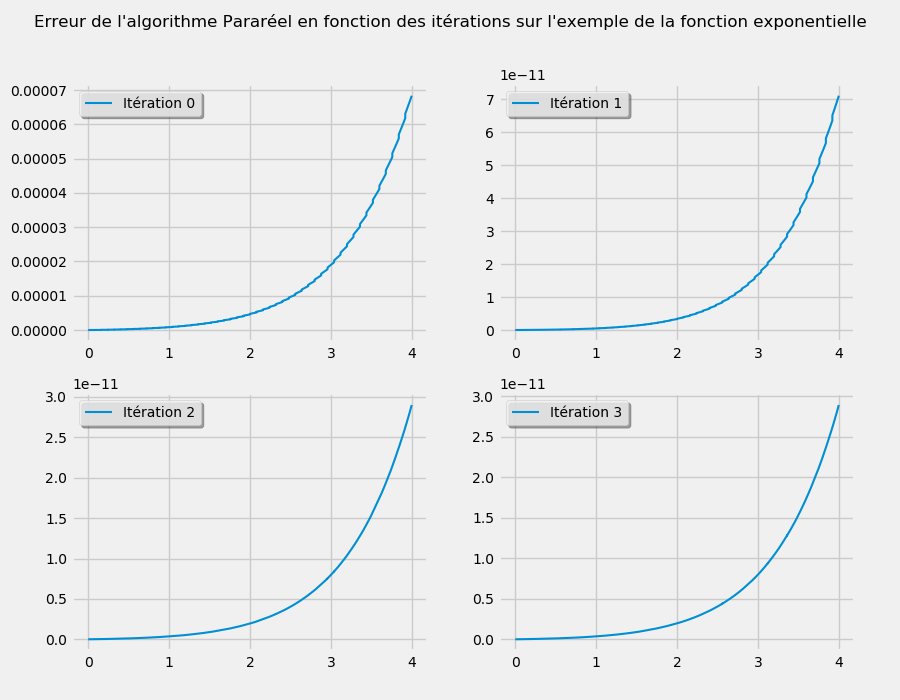

In [15]:
tt,Fn,Gn,FN=parareal(fexp,RK4,40,RK4,50,4,np.array([1]),4)
plt.figure()
for k in range(4):
    plt.subplot(2,2,k+1)
    plt.plot(tt,np.abs(np.exp(tt[:])-FN[k,:,0]),label=f'Itération {k}')
    plt.legend()
plt.suptitle("Erreur de l'algorithme Pararéel en fonction des itérations sur l'exemple de la fonction exponentielle")
plt.show()

On se propose maintenant d'étudier l'erreur de chaque méthode sur l'exemple de l'exponentielle. On applique donc toutes les méthodes à l'équation $\dot{y}=y$ de condition initiale $y(0)=1$. On étudie alors cette équation sur l'intervalle $[0,1]$. On va donc étudier l'erreur en fonction du pas de temps $\Delta t$. Pour cela on va faire varier le nombre de sous-intervalles pour les différentes méthodes. De plus, on décide d'utiliser une échelle logarithmique pour obtenir une bonne visualisation.

On représente donc l'ordre de chacune des méthodes précédemment citées.

<IPython.core.display.Javascript object>


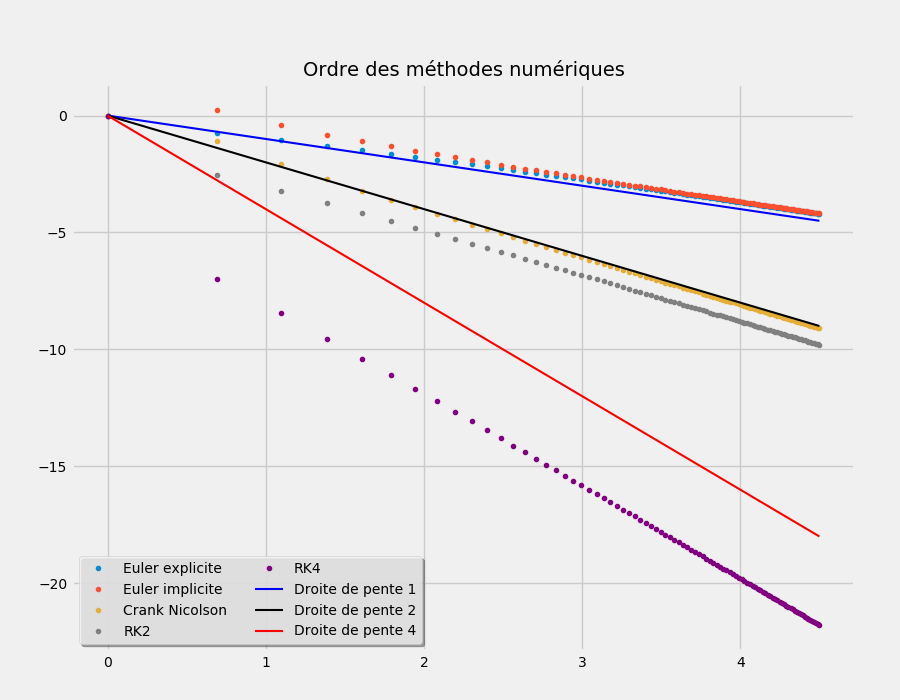

In [16]:
t0,tf,y0,N=0,1,1,90
X,EE,EI,CN,H,rk2,rk4=[0],[0],[0],[0],[0],[0],[0]
for n in range(2,N+1):
    X.append(np.log(n))
    EE.append(np.log(abs(np.exp(1)-EulerExplicite(fexp,t0,tf,y0,n)[1][-1])))
    EI.append(np.log(abs(np.exp(1)-EulerImplicite(fexp,t0,tf,y0,n)[1][-1])))
    CN.append(np.log(abs(np.exp(1)-CrankNicolson(fexp,t0,tf,y0,n)[1][-1])))
    rk2.append(np.log(abs(np.exp(1)-RK2(fexp,t0,tf,y0,n)[1][-1])))
    rk4.append(np.log(abs(np.exp(1)-RK4(fexp,t0,tf,y0,n)[1][-1])))
plt.figure()
plt.plot(X,EE,'.',label='Euler explicite')
plt.plot(X,EI,'.',label="Euler implicite")
plt.plot(X,CN,'.',label="Crank Nicolson")
plt.plot(X,rk2,'.',color='gray',label="RK2")
plt.plot(X,rk4,'.',color='purple',label="RK4")
plt.plot(X,[-x for x in X],'-',color='blue',label="Droite de pente 1")
plt.plot(X,[-2*x for x in X],'-',color='black',label="Droite de pente 2")
plt.plot(X,[-4*x for x in X],'-',color='red',label="Droite de pente 4")
plt.legend(loc='best',ncol=2)
plt.title("Ordre des méthodes numériques",fontsize=14)

plt.show()

On retrouve bien les résultats prouvés dans la partie théorique du rapport : 
1. Les méthodes d'Euler sont d'ordre 1 (droite de pente 1);
1. La méthode Crank-Nicolson est d'ordre 2 (droite de pente 2);
1. La méthode RK2 est d'ordre 2 (droite de pente 2);
1. La méthode RK4 est d'ordre 4 (droite de pente 4).

On choisit alors de réaliser la même représentation pour différents paramètres de la $\theta$-méthode. Pour cela, on fait varier le paramètre $\theta$ entre entre $0$ et $1$ avec un pas de $0.1$.

<IPython.core.display.Javascript object>


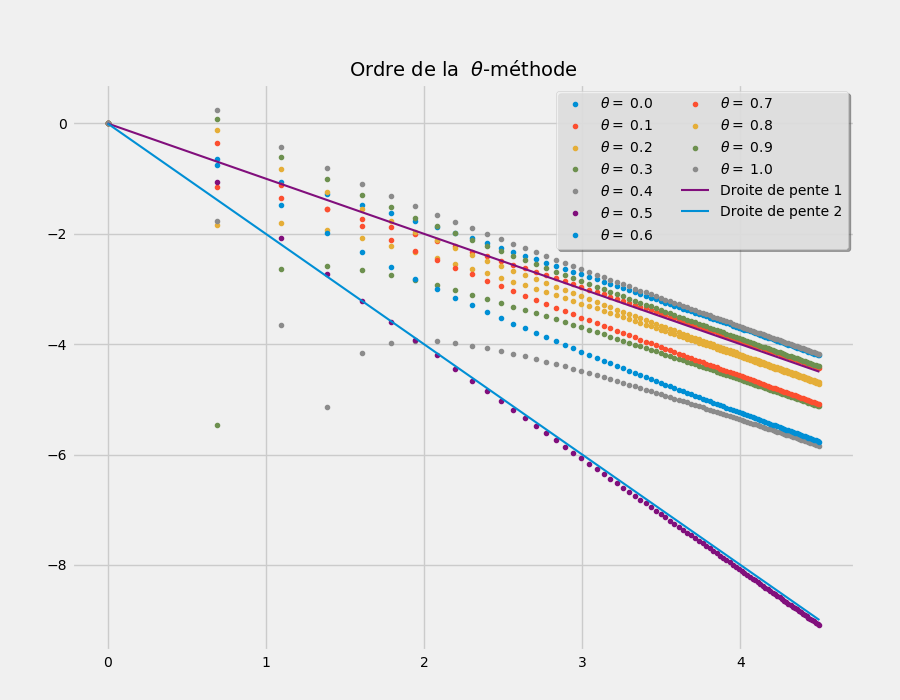

In [17]:
t0,tf,y0,N=0,1,1,90
theta_methode=np.zeros((11,N))
plt.figure()
for i in range(0,11):
    X=[0]
    theta=i/10
    for n in range(2,N+1):
        X.append(np.log(n))
        theta_methode[i,n-1]=np.log(abs(np.exp(1)-thetamethode(fexp,t0,tf,y0,n,theta)[1][-1]))
    plt.plot(X,theta_methode[i,:],'.',label=fr'$\theta=$ {theta}')

plt.plot(X,[-x for x in X],label="Droite de pente 1")
plt.plot(X,[-2*x for x in X],label="Droite de pente 2")

plt.legend(loc='best',ncol=2)
plt.title(r"Ordre de la  $\theta$-méthode",fontsize=14)

plt.show()


On observe alors bien que le $\theta$-schéma est d'ordre $1$ pour tout paramètre $\theta \neq \frac{1}{2} $ et d'ordre $2$ pour $\theta=\frac{1}{2}$.

### La fonction sinus <a name="3.1.2"></a>

On prend ici l'éqaution : 
$$ \dot{y}(t) = \cos(t). $$
On connait alors la solution exacte. On a en effet : $$y(t) = \sin(t). $$
On va donc pouvoir appliquer les différentes méthodes de résolution à cette équation différentielle puis tracer la résultat obtenu ainsi que la courbe de la fonction sinus. On va également pouvoir en profiter pour calculer l'erreur de chaque méthode pour cette équation.

In [18]:
def fsin(Y,t) : 
    return(np.cos(t))

<IPython.core.display.Javascript object>


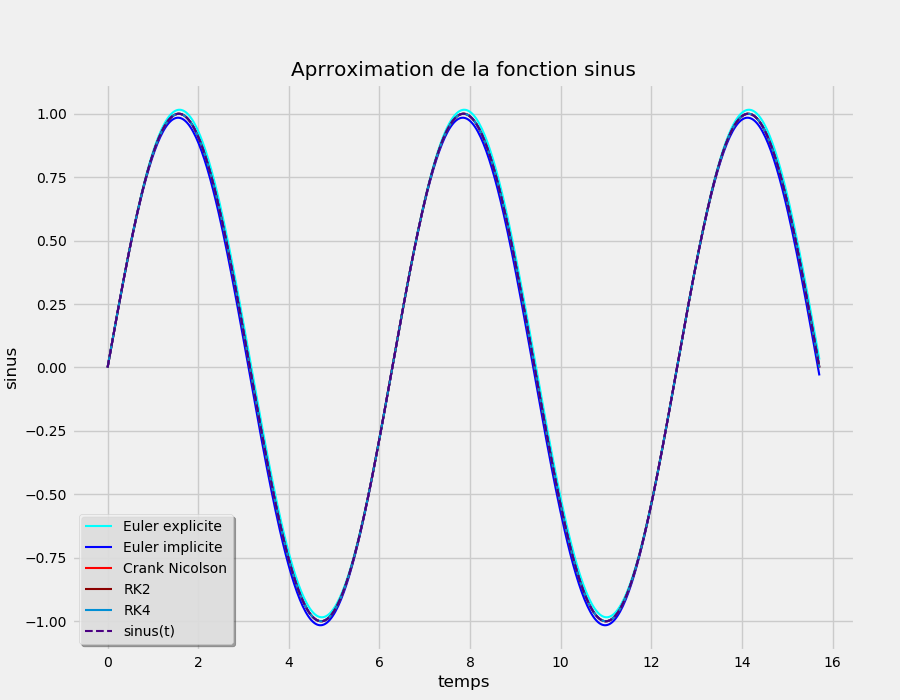

In [19]:
t0,tf,y0,n=0,5*np.pi,0,500

temps,euler_explicite=EulerExplicite(fsin,t0,tf,y0,n)
euler_implicite=EulerImplicite(fsin,t0,tf,y0,n)[1]
crank_nicolson=CrankNicolson(fsin,t0,tf,y0,n)[1]
rk2=RK2(fsin,t0,tf,y0,n)[1]
rk4=RK4(fsin,t0,tf,y0,n)[1]

plt.figure()
plt.plot(temps,euler_explicite,color='cyan',label="Euler explicite")
plt.plot(temps,euler_implicite,color='blue',label="Euler implicite")
plt.plot(temps,crank_nicolson,color='red',label="Crank Nicolson")
plt.plot(temps,rk2,color='darkred',label="RK2")
plt.plot(temps,rk4,label="RK4")
plt.plot(temps,np.sin(temps),'--',color='indigo',label="sinus(t)")
plt.xlabel("temps")
plt.ylabel("sinus")
plt.title("Aprroximation de la fonction sinus")
plt.legend()
plt.show()

## Les exemples bidimensionnels <a name="3.2"></a>

### Les équations de Lotka-Volterra <a name="3.2.1"></a>

Nous allons maintenant étudier le système de Lotka-Volterra. Posons tout d'abord le système d'équations :

\begin{equation}
\begin{cases} \dot{x}(t)= ax(t)-bx(t)y(t) \\\dot{y}(t)=-cy(t)+dx(t)y(t) \end{cases} \ \ \ \ (x(0),y(0))=(x_0,y_0).
\end{equation}

On prendra ici les paramètres $a=3$, $b=1$, $c=2$ et $d=1$.

In [20]:
def fLV(Y,t) : 
    x,y=Y[0],Y[1]
    a,b,c,d=3,1,2,1
    xdot=a*x - b*x*y
    ydot=-c*y +d*x*y
    return (np.array([xdot,ydot]))

On va donc tracer pour chaque méthode utilisée deux graphiques différents : l'évolution de chaque population en fonction du temps et le portrait de phase.

<IPython.core.display.Javascript object>


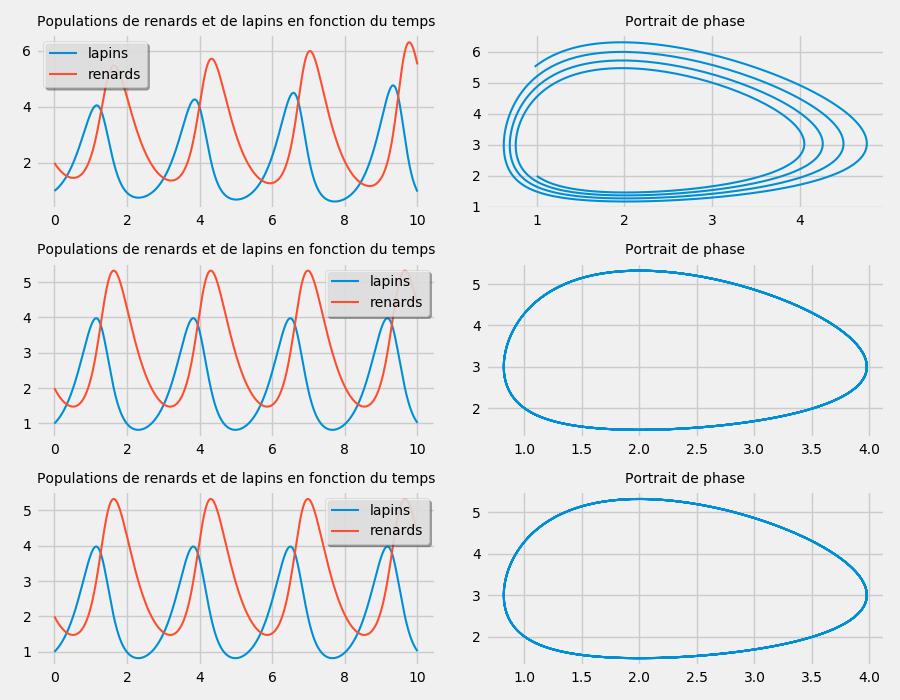

In [21]:
Y0=np.array([1,2])
sol = EulerExplicite(fLV,0,10,Y0, 1000)
temps,Y=sol[0],sol[1]
plt.figure()
Y=np.array(Y)
lapins,renards=Y[:,0],Y[:,1]
plt.subplot(3, 2, 1)
plt.plot(temps,lapins,label="lapins")
plt.plot(temps,renards,label="renards")
plt.legend(fontsize=10)
plt.title("Populations de renards et de lapins en fonction du temps",fontsize=10)
plt.show()
plt.subplot(3, 2, 2)
plt.plot(lapins,renards)
plt.title("Portrait de phase",fontsize=10)

Y0=np.array([1,2])
sol = RK2(fLV,0,10,Y0, 1000)
temps,Y=sol[0],sol[1]

Y=np.array(Y)
lapins,renards=Y[:,0],Y[:,1]
plt.subplot(3, 2, 3)
plt.plot(temps,lapins,label="lapins")
plt.plot(temps,renards,label="renards")
plt.legend(fontsize=10)
plt.title("Populations de renards et de lapins en fonction du temps",fontsize=10)
plt.show()
plt.subplot(3, 2, 4)
plt.plot(lapins,renards)
plt.title("Portrait de phase",fontsize=10)
plt.show()

Y0=np.array([1,2])
sol = RK4(fLV,0,10,Y0, 1000)
temps,Y=sol[0],sol[1]
Y=np.array(Y)
lapins,renards=Y[:,0],Y[:,1]
plt.subplot(3, 2, 5)
plt.plot(temps,lapins,label="lapins")
plt.plot(temps,renards,label="renards")
plt.legend(fontsize=10)
plt.title("Populations de renards et de lapins en fonction du temps",fontsize=10)
plt.show()
plt.subplot(3, 2, 6)
plt.plot(lapins,renards)
plt.title("Portrait de phase",fontsize=10)
plt.tight_layout()
plt.show()


### Le Brusselator <a name="3.2.2"></a>

Etudions maintenant l'exemple du modèle du Brusselator. Ce modèle est utilisé en chimie dans le cadre de réactions autocatalytiques.

On va pour cela réaliser différents graphiques pour visualiser les avantages et inconvénients de quelques-unes de nos différentes méthodes. Tout d'abord, définissons le système différentiel suivant : 

$$ \begin{cases} \dot{x}(t) = A + x(t)^2 y(t) - (B + 1)x(t) \\ \dot{y}(t) =  Bx(t) − x(t)^2 y(t). \end{cases} $$

On prendra dans notre cas $A=1$, $B=3$ en paramètres. De plus, on pose la condition initiale $(x_0,y_0)=(0,1)$ et on étudie le système sur l'intervalle $[0,12].$

In [22]:
def fBruss(Y,t) : 
    A=1
    B=3
    x,y=Y[0],Y[1]
    xdot=A+x**2*y-(B+1)*x 
    ydot=B*x-x**2*y
    return np.array([xdot,ydot])

<IPython.core.display.Javascript object>


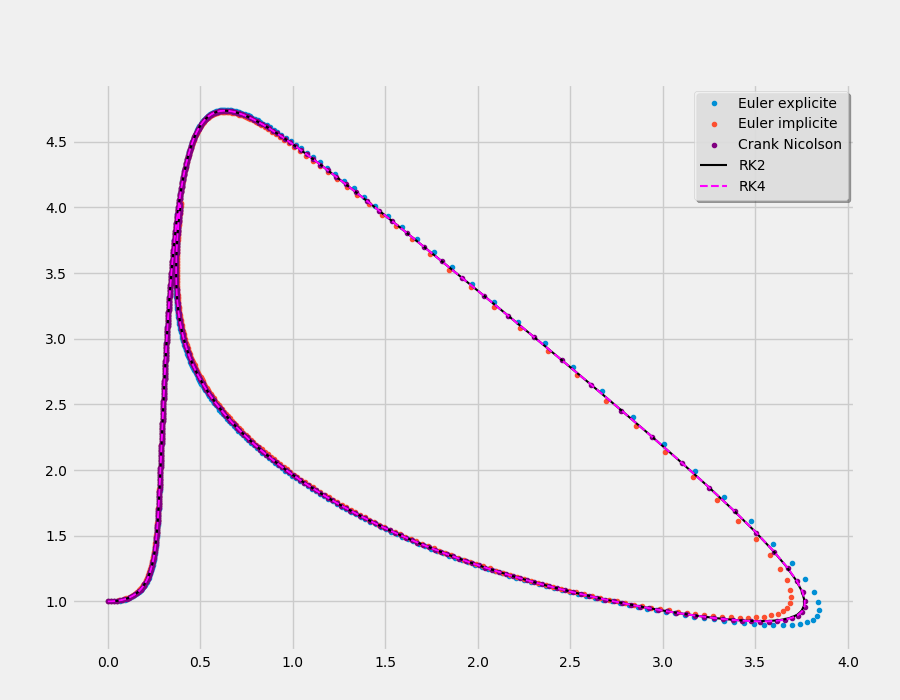

In [23]:
t0,T,y0,N=0,12,np.array([0,1]),32*20

temps,euler_explicite=EulerExplicite(fBruss,t0,T,y0,N)
euler_implicite=np.array(EulerImplicite(fBruss,t0,T,y0,N)[1])
crank_nicolson=np.array(CrankNicolson(fBruss,t0,T,y0,N)[1])
rk2=np.array(RK2(fBruss,t0,T,y0,N)[1])
rk4=np.array(RK4(fBruss,t0,T,y0,N)[1])
plt.figure()
plt.plot(np.array(euler_explicite)[:,0],np.array(euler_explicite)[:,1],'.',label="Euler explicite")
plt.plot(euler_implicite[:,0],euler_implicite[:,1],'.',label="Euler implicite")
plt.plot(crank_nicolson[:,0],crank_nicolson[:,1],'.',color='purple',label="Crank Nicolson")
plt.plot(rk2[:,0],rk2[:,1],'-',color='black',label="RK2")
plt.plot(rk4[:,0],rk4[:,1],'--',color='magenta',label="RK4")
plt.legend()
plt.show()

On veut représenter maintenant l'erreur entre l'algorithme Pararéel et la méthode `RK4` sur cet exemple.

<IPython.core.display.Javascript object>


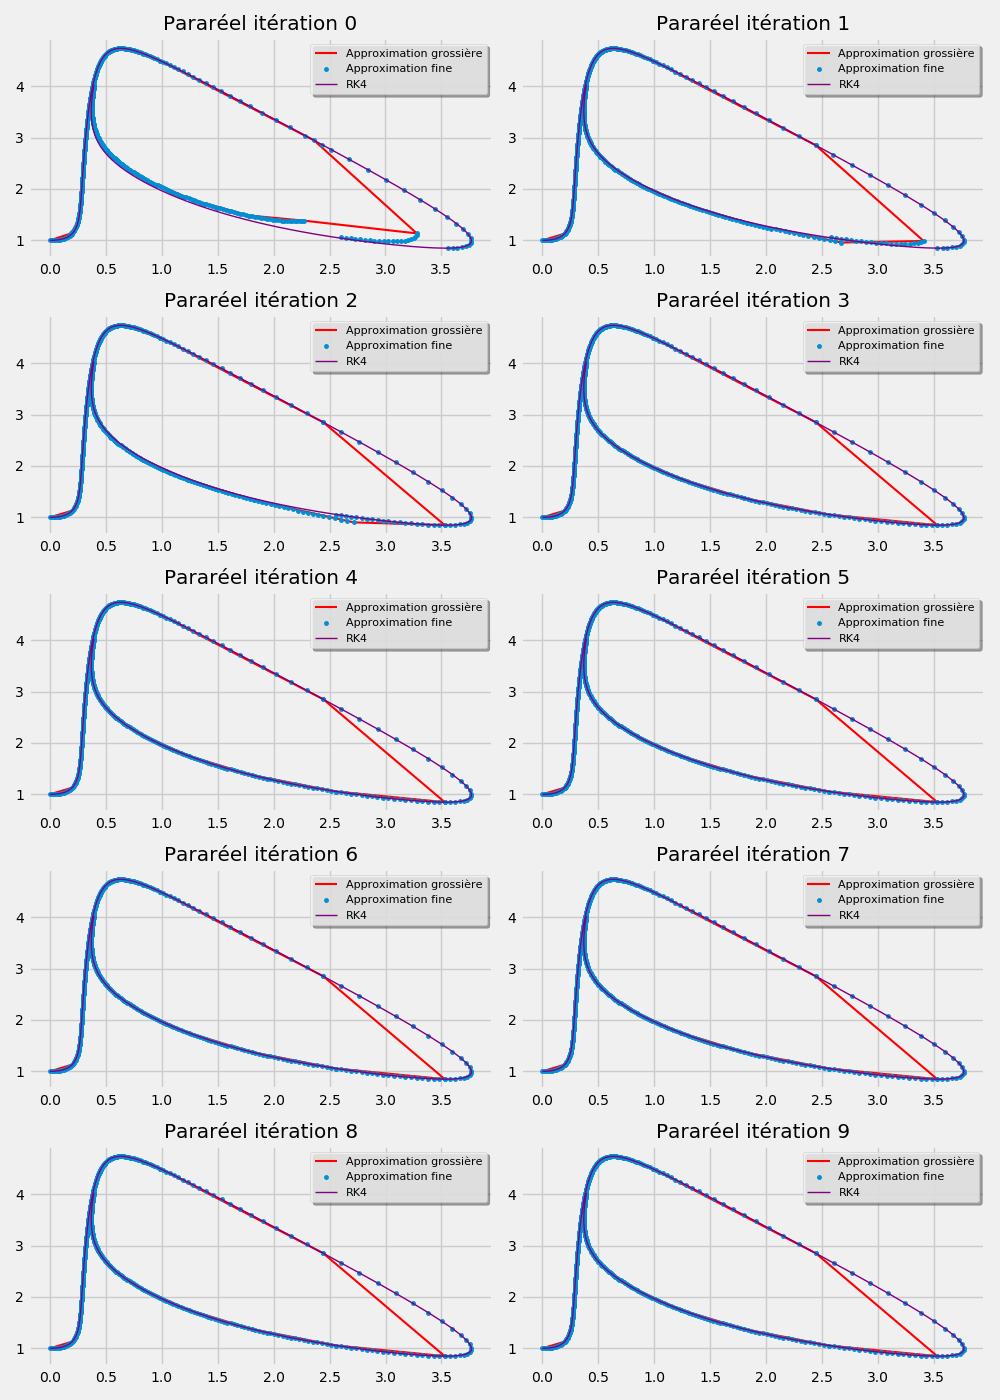

In [24]:
T,NG,NF,y0,K=12,32,20,np.array([0,1]),10
tt,Fn,Gn,FN=parareal(fBruss,RK4,NF,RK4,NG,T,y0,K)
tt,RK=RK4(fBruss,0,T,y0,NG*NF)
RK=np.array(RK)
plt.figure(figsize=(10,14))
for k in range(K) :
    plt.subplot(int(K/2),2,k+1)
    plt.plot(Gn[k,:,0],Gn[k,:,1],'-',color='red',label="Approximation grossière")
    plt.plot(FN[k,:,0],FN[k,:,1],'.',ms=5,label="Approximation fine")
    plt.plot(RK[:,0],RK[:,1],'-',linewidth=1,color='purple',label="RK4")
    plt.legend(fontsize=8)
    plt.title(f"Pararéel itération {k}")
    plt.tight_layout()
plt.show()

On voit avec cet exemple que, dès le second graphique, l'algorithme Pararéel semble très proche de la solution obtenue avec la méthode `RK4`. On décide alors de représenter l'erreur en fonction des itérations sur les graphiques suivants.

**Remarque :** pour calculer l'erreur, on doit se ramener à deux vecteurs solution de même longueur. Pour cela, on va enlever le dernier point de chaque sous-intervalle grossier qui, au fil des itérations coincide avec le premier point du sous-intervalle grossier suivant. Cette erreur est négligeable lorsque l'on utilise beaucoup de points et devient nulle au fil des itérations.

<IPython.core.display.Javascript object>


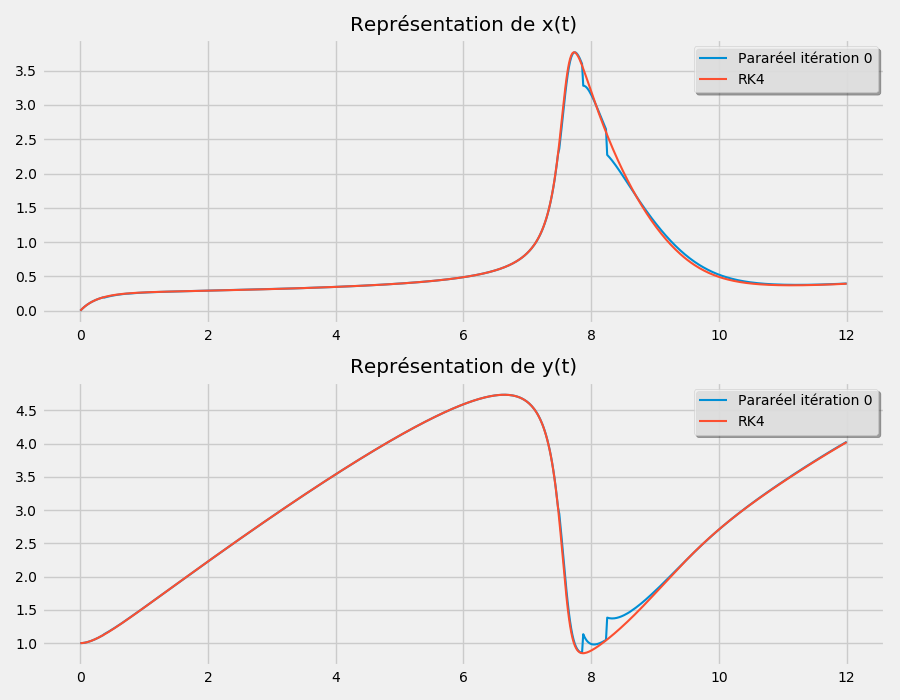

<IPython.core.display.Javascript object>


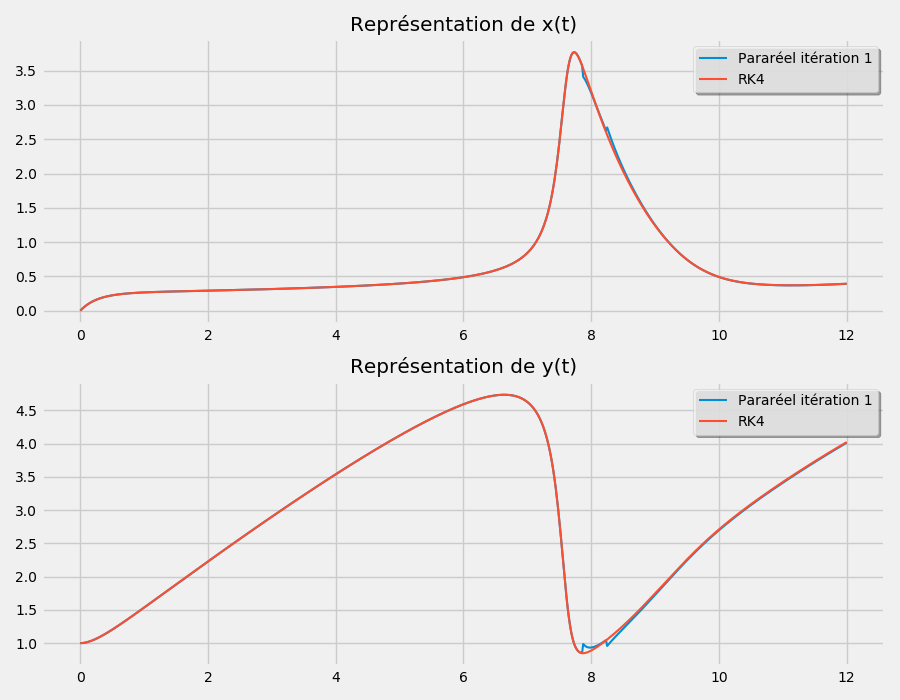

<IPython.core.display.Javascript object>


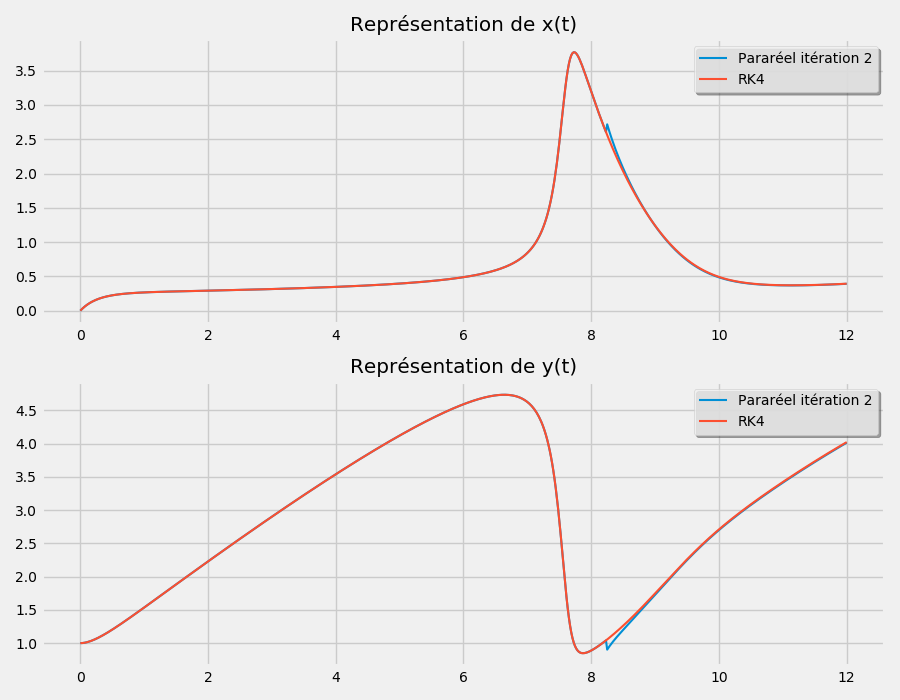

<IPython.core.display.Javascript object>


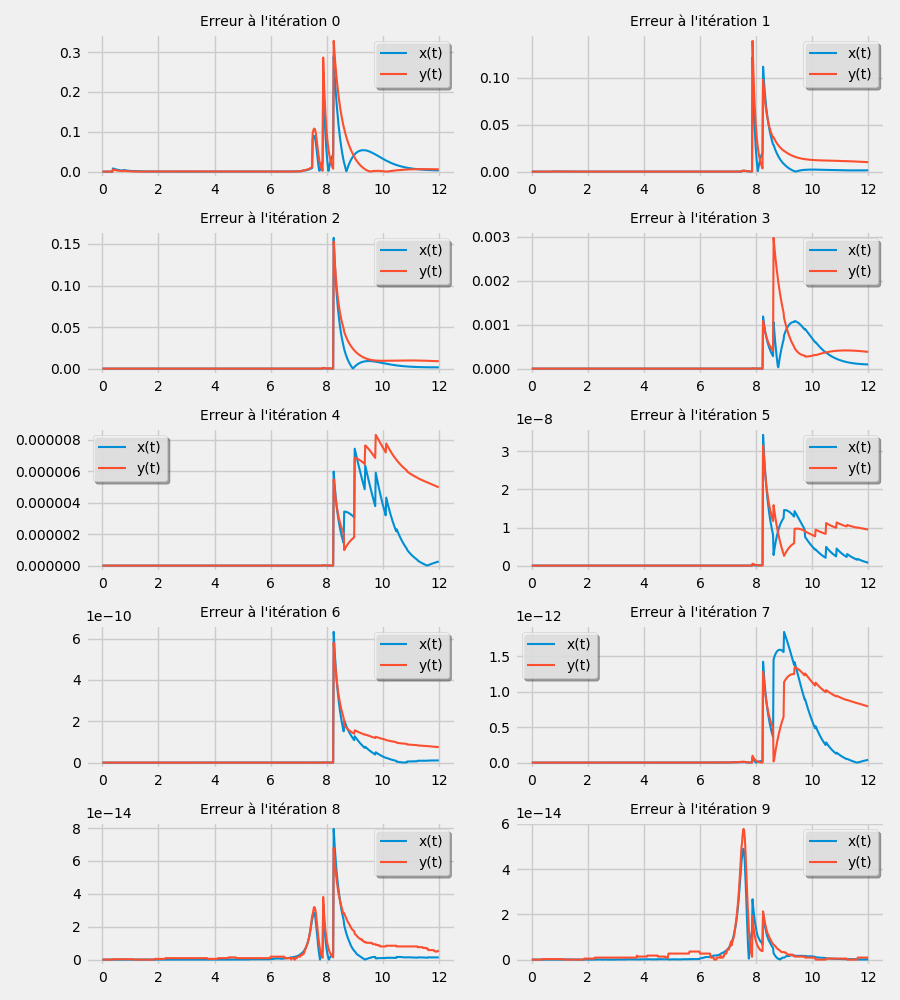

<IPython.core.display.Javascript object>


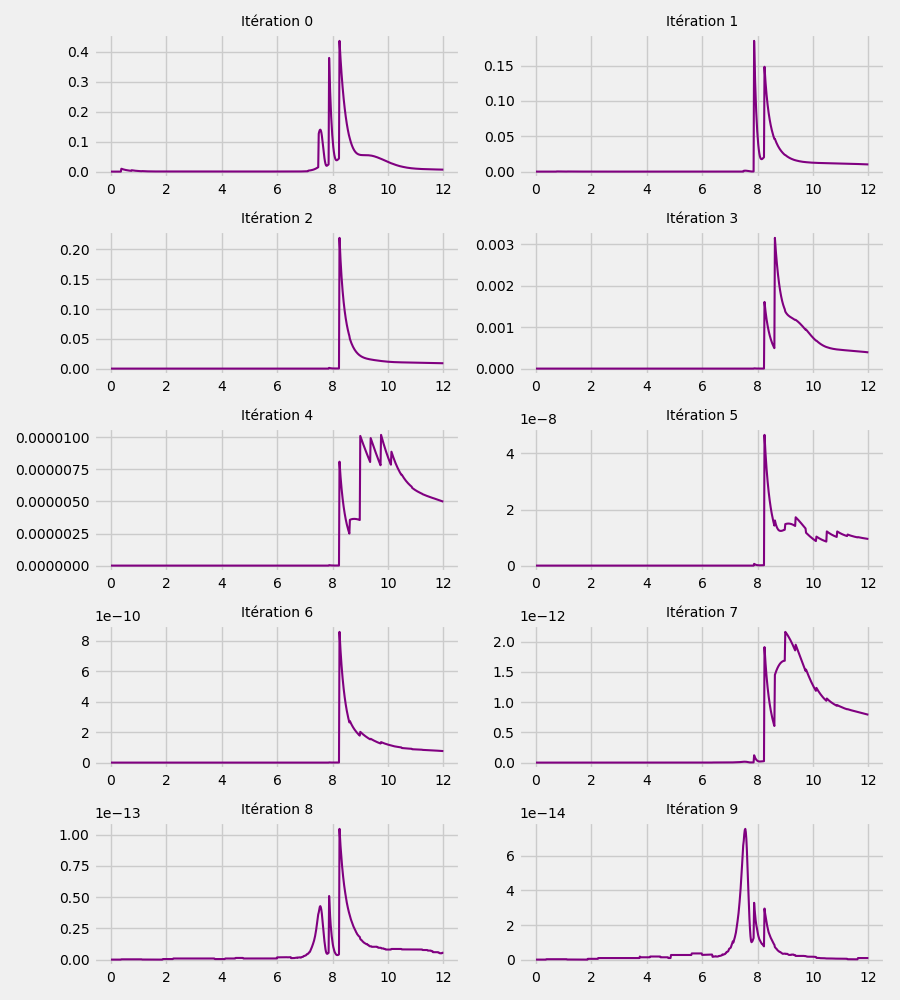

In [25]:
fn=np.zeros((K,NG*NF+1,len(y0)),float)
for k in range(K):
    fn[k,:-1,:]=np.concatenate(Fn[k,:,:-1,:],axis=0)
    fn[k,-1,:]=Fn[k,-1,-1,:]
xRK4,yRK4=RK[:,0],RK[:,1]

for k in range(3) :
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(tt,fn[k,:,0],label=f'Pararéel itération {k}')
    plt.plot(tt,xRK4[:],label="RK4")
    plt.title("Représentation de x(t)")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(tt,fn[k,:,1],label=f'Pararéel itération {k}')
    plt.plot(tt,yRK4[:],label="RK4")
    plt.title("Représentation de y(t)")
    plt.legend()
    plt.tight_layout()

err=np.zeros((K,NF*NG+1,len(y0)),float)
plt.figure(figsize=(9,K))
for k in range(K) :
    err[k,:,0],err[k,:,1]=np.abs(fn[k,:,0]-xRK4[:]),np.abs(fn[k,:,1]-yRK4[:])
    plt.subplot(int(K/2),2,k+1)
    plt.plot(tt,err[k,:,0],label=f'x(t)')
    plt.plot(tt,err[k,:,1],label=f'y(t)')
    plt.legend(fontsize=10)
    plt.title(f"Erreur à l'itération {k}",fontsize=10)
    plt.tight_layout()
    
Erreur=np.zeros((K,NF*NG+1),float)
plt.figure(figsize=(9,K))
for k in range(K) :
    Erreur[k,:]=np.sqrt(err[k,:,0]**2+err[k,:,1]**2)
    plt.subplot(int(K/2),2,k+1)
    plt.plot(tt,Erreur[k,:],color='purple')
    plt.title(f"Itération {k}",fontsize=10)   
    plt.tight_layout()

**Remarque : on voit ici que l'on se rapproche très vite de la précision machine. On peut donc supposer que les "pics" d'erreur à partir de l'itération 2 proviennent d'erreurs d'arrondi en lien avec l'arithmétique flottante. On réalise en effet l'erreur entre deux approximations, cela crée donc une erreur supplémentaire. On reste ici très proche de la précision machine. Cela sera également valable pour les prochains exemples.**

**Pour cette raison notamment, la précision de la méthode RK4 pourra difficilement être meilleure que $10^{-14}$, ce qui implique nécessairement que les résultats seront rarement meilleurs que $10^{-14}$ sur l'algorithme Pararéel, ce qui est déjà très proche de la précision machine.**

## Les exemples tridimensionnels <a name="3.3"></a>

### Les équations de Lorenz <a name="3.3.1"></a>

Le système d'équations de Lorenz est un modèle de prédiction de la météo. Il est dit chaotique car une modification de la condition initiale, si petite soit elle, modifie complètement la solution obtenue sur un temps long. Ce système est le suivant : 

$$\begin{cases}
\dot{x}(t)=\sigma (y(t)-x(t)) \\ \dot{y}(t) = \rho x(t) -y(t) -x(t)z(t) \\ \dot{z}(t)=x(t)y(t) -\beta z(t).
\end{cases}
$$
Avec $t\in [0,T]$, $\sigma$, $\rho$, $\beta \in \mathbb{R}^+$.

In [26]:
sigma, rho, b = 10,28,8/3

def fLorenz(Y,t) : 
    x,y,z=Y[0],Y[1],Y[2]
    xdot=sigma*(y-x) 
    ydot=rho*x-y-x*z
    zdot=x*y-z*b
    return np.array([xdot,ydot,zdot])

In [27]:
Y0=np.array([5 ,-5,20])
T=4
solEE=EulerExplicite(fLorenz,0,T,Y0,4000)
solEI=np.array(EulerImplicite(fLorenz,0,T,Y0,4000)[1])
solCN=np.array(CrankNicolson(fLorenz,0,T,Y0,4000)[1])
solRK2=np.array(RK2(fLorenz,0,T,Y0,4000)[1])
solRK4=np.array(RK4(fLorenz,0,T,Y0,4000)[1])

temps,YEE=solEE
YEE=np.array(YEE)
xEE,yEE,zEE=YEE[:,0],YEE[:,1],YEE[:,2]

xEI,yEI,zEI=solEI[:,0],solEI[:,1],solEI[:,2]
xRK2,yRK2,zRK2=solRK2[:,0],solRK2[:,1],solRK2[:,2]
xRK4,yRK4,zRK4=solRK4[:,0],solRK4[:,1],solRK4[:,2]
xCN,yCN,zCN=solCN[:,0],solCN[:,1],solCN[:,2]


<IPython.core.display.Javascript object>


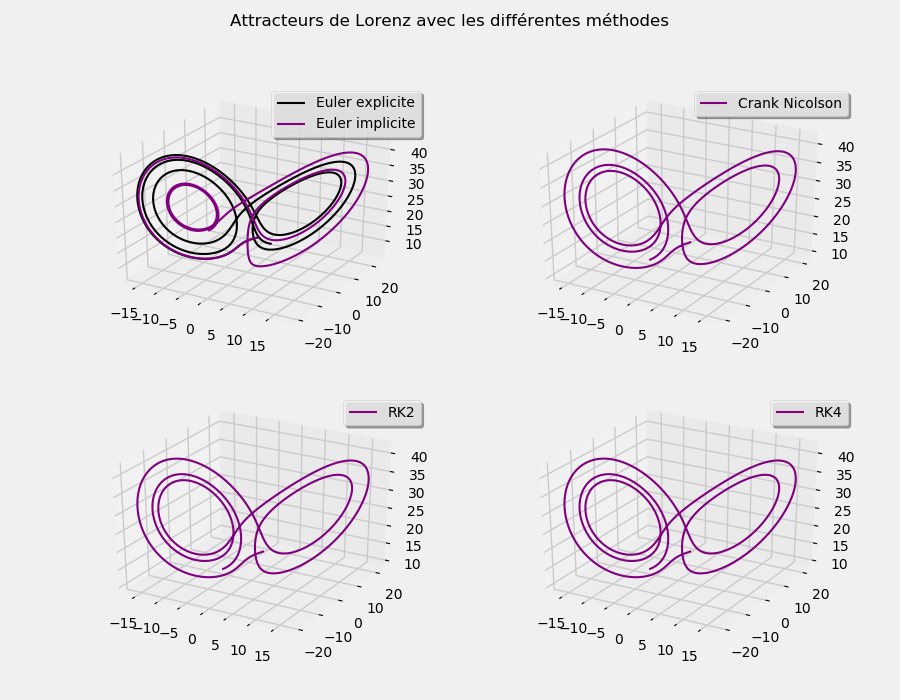

In [28]:
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot(xEE,yEE,zEE,'-',color='black',label="Euler explicite")
ax.plot(xEI,yEI,zEI,'-',color='purple',label="Euler implicite")
ax.legend()

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot(xCN,yCN,zCN,'-',color='purple',label="Crank Nicolson")
ax.legend()

ax=fig.add_subplot(2,2,3,projection='3d')
ax.plot(xRK2,yRK2,zRK2,'-',color='purple',label="RK2")
ax.legend()

ax=fig.add_subplot(2,2,4,projection='3d')
ax.plot(xRK4,yRK4,zRK4,'-',color='purple',label="RK4")
ax.legend()

plt.suptitle("Attracteurs de Lorenz avec les différentes méthodes")
plt.show()


<IPython.core.display.Javascript object>


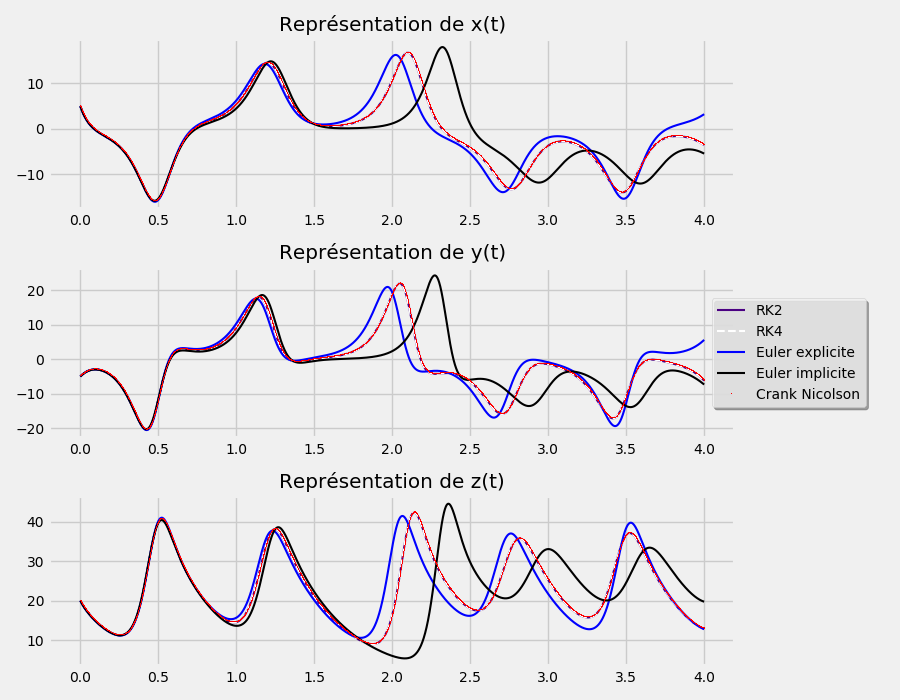

In [29]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(temps,xRK2,'-',color='indigo',label="RK2")
plt.plot(temps,xRK4,'--',color='white',label="RK4")
plt.plot(temps,xEE,color='blue',label="Euler explicite")
plt.plot(temps,xEI,color='black',label="Euler implicite")
plt.plot(temps,xCN,',',color='red',label="Crank Nicolson")
plt.title("Représentation de x(t)")
plt.show()
plt.subplot(3,1,2)
plt.plot(temps,yRK2,'-',color='indigo',label="RK2")
plt.plot(temps,yRK4,'--',color='white',label="RK4")
plt.plot(temps,yEE,color='blue',label="Euler explicite")
plt.plot(temps,yEI,color='black',label="Euler implicite")
plt.plot(temps,yCN,',',color='red',label="Crank Nicolson")
plt.title("Représentation de y(t)")
plt.show()
plt.legend(loc="center right",bbox_to_anchor=(1.2,0.5),ncol=1)
plt.subplot(3,1,3)
plt.plot(temps,zRK2,'-',color='indigo',label="RK2")
plt.plot(temps,zRK4,'--',color='white',label="RK4")
plt.plot(temps,zEE,color='blue',label="Euler explicite")
plt.plot(temps,zEI,color='black',label="Euler implicite")
plt.plot(temps,zCN,',',color='red',label="Crank Nicolson")
plt.title("Représentation de z(t)")
plt.show()
plt.tight_layout()


Maintenant que nous avons visualisé la différence de précision entre les méthodes numériques, on souhaite visualiser tout d'abord le résultat obtenu à l'aide de l'algorithme Pararéel puis, on effectuera des comparaisons entre cet algorithme et la méthode la plus précise : `RK4`.

<IPython.core.display.Javascript object>


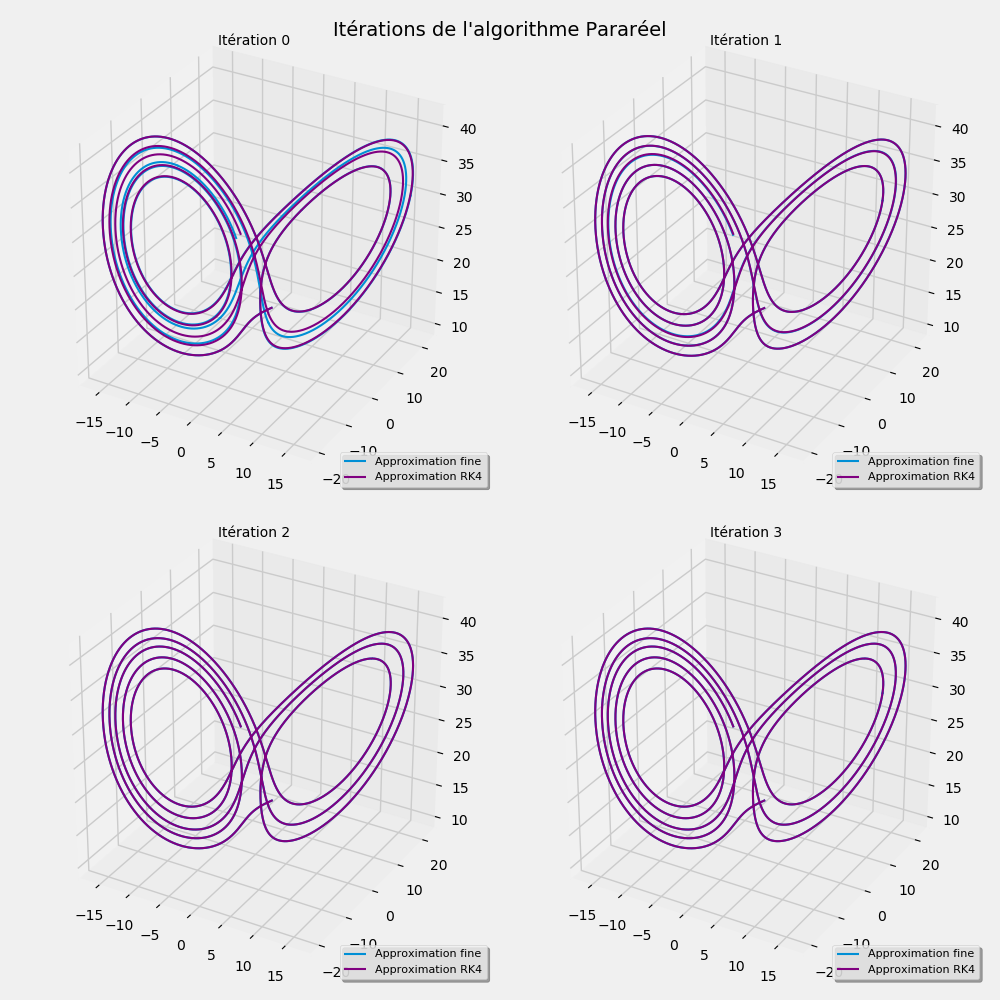

In [30]:
K=12
y0=np.array([5,-5,20])
T=6
NF,NG,Fin,Grossier=80,180,RK4,RK4
tt,Fn,Gn,FN=parareal(fLorenz,Fin,NF,Grossier,NG,T,y0,K)
tt,solRK4=RK4(fLorenz,0,T,y0,NG*NF)
solRK4=np.array(solRK4)
xRK4,yRK4,zRK4=solRK4[:,0],solRK4[:,1],solRK4[:,2]
fig = plt.figure(figsize=(10,10))
for k in range(0,4) : 

    ax = fig.add_subplot(2, 2, k+1, projection='3d')
    ax.plot(FN[k,:,0],FN[k,:,1],FN[k,:,2],'-',label="Approximation fine")
    ax.plot(xRK4[:],yRK4[:],zRK4[:],'-',color='purple',label="Approximation RK4")
    ax.legend(loc='lower right',fontsize=8)
    plt.title(f'Itération {k}',fontsize=10)
plt.suptitle("Itérations de l'algorithme Pararéel",fontsize=14)
plt.tight_layout()
plt.show()


In [31]:
fn=np.zeros((K,NF*NG+1,3),float)
for k in range(K):
    fn[k,:-1,:]=np.concatenate(Fn[k,:,:-1,:],axis=0)
    fn[k,-1,:]=Fn[k,-1,-1,:]

<IPython.core.display.Javascript object>


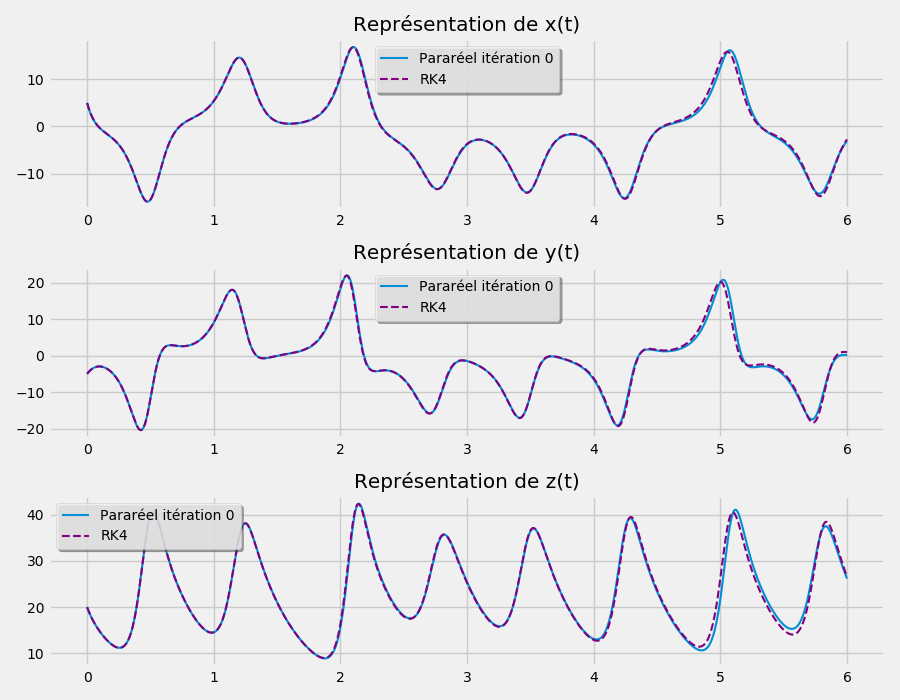

<IPython.core.display.Javascript object>


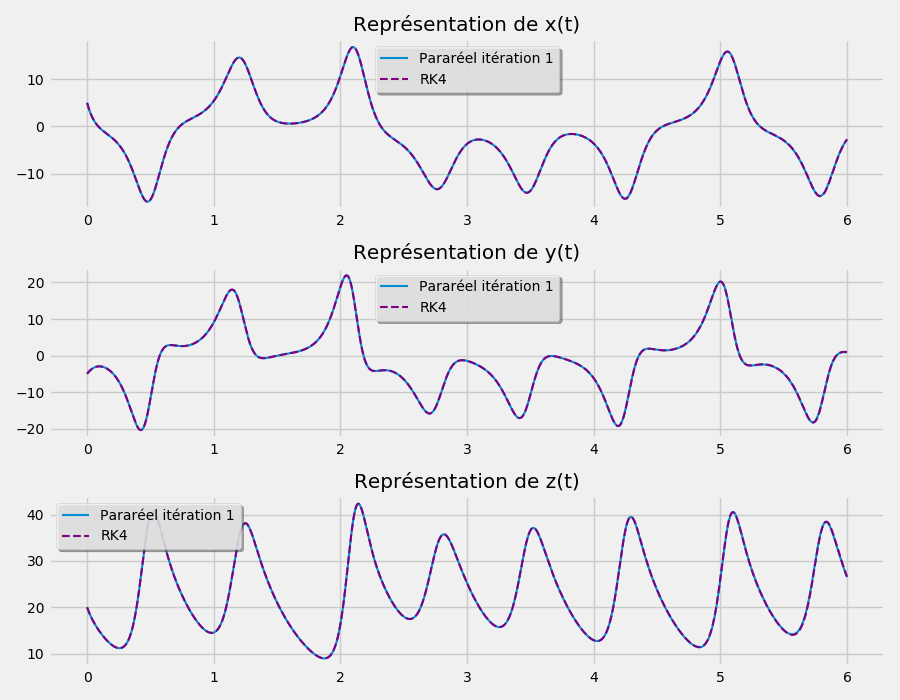

In [32]:
for k in range(0,2) :
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(tt,fn[k,:,0],label=f'Pararéel itération {k}')
    plt.plot(tt,xRK4[:],'--',color='purple',label="RK4")
    plt.title("Représentation de x(t)")
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(tt,fn[k,:,1],label=f'Pararéel itération {k}')
    plt.plot(tt,yRK4[:],'--',color='purple',label="RK4")
    plt.title("Représentation de y(t)")
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(tt,fn[k,:,2],label=f'Pararéel itération {k}')
    plt.plot(tt,zRK4[:],'--',color='purple',label="RK4")
    plt.title("Représentation de z(t)")
    plt.legend()
    plt.tight_layout()
    

<IPython.core.display.Javascript object>


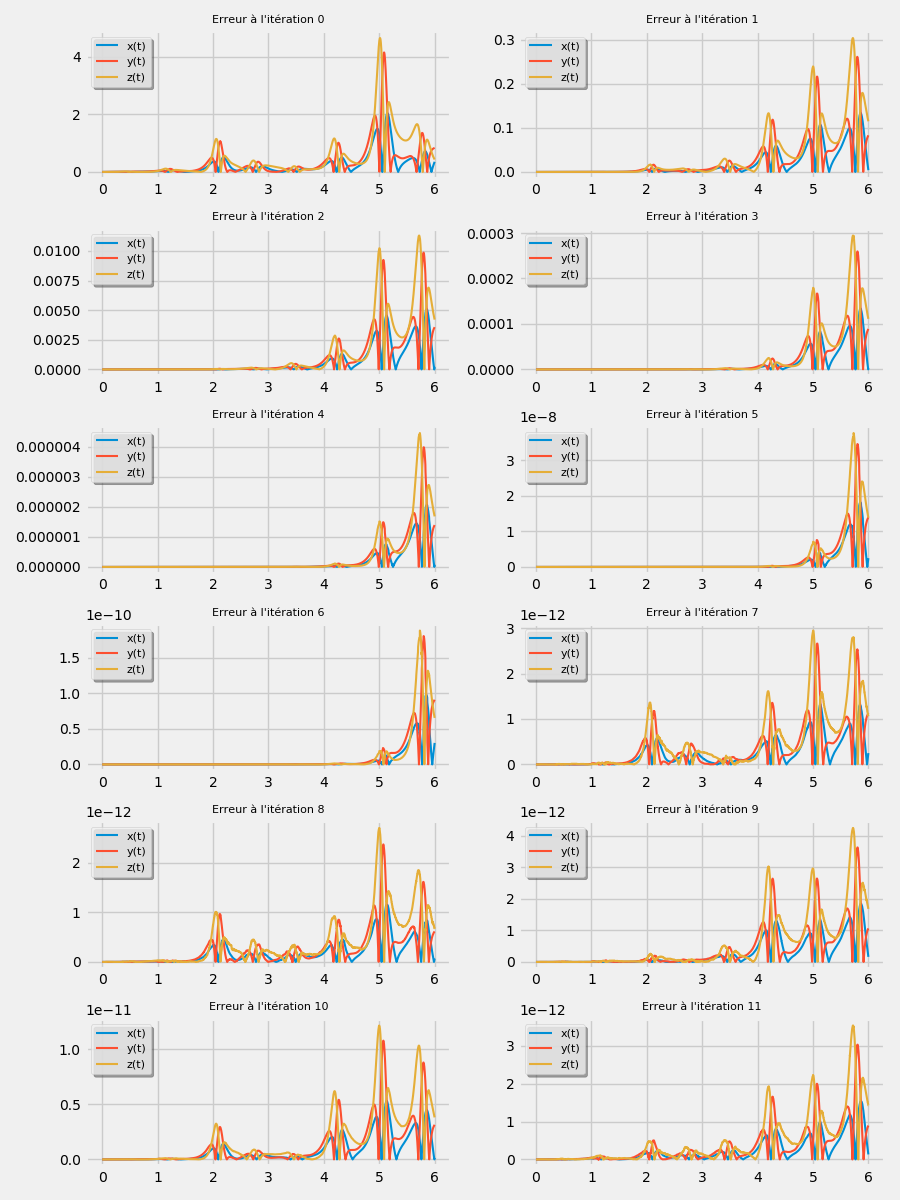

In [33]:
err=np.zeros((K,NG*NF+1,3),float)
plt.figure(figsize=(9,K))
for k in range(K) :
    err[k,:,0],err[k,:,1],err[k,:,2]=np.abs(fn[k,:,0]-xRK4[:]),np.abs(fn[k,:,1]-yRK4[:]),np.abs(fn[k,:,2]-zRK4[:])
    plt.subplot(int(K/2),2,k+1)
    plt.plot(tt,err[k,:,0],label=f'x(t)')
    plt.plot(tt,err[k,:,1],label=f'y(t)')
    plt.plot(tt,err[k,:,2],label=f'z(t)')
    plt.legend(fontsize=8)
    plt.title(f"Erreur à l'itération {k}",fontsize=8)
    plt.tight_layout()


<IPython.core.display.Javascript object>


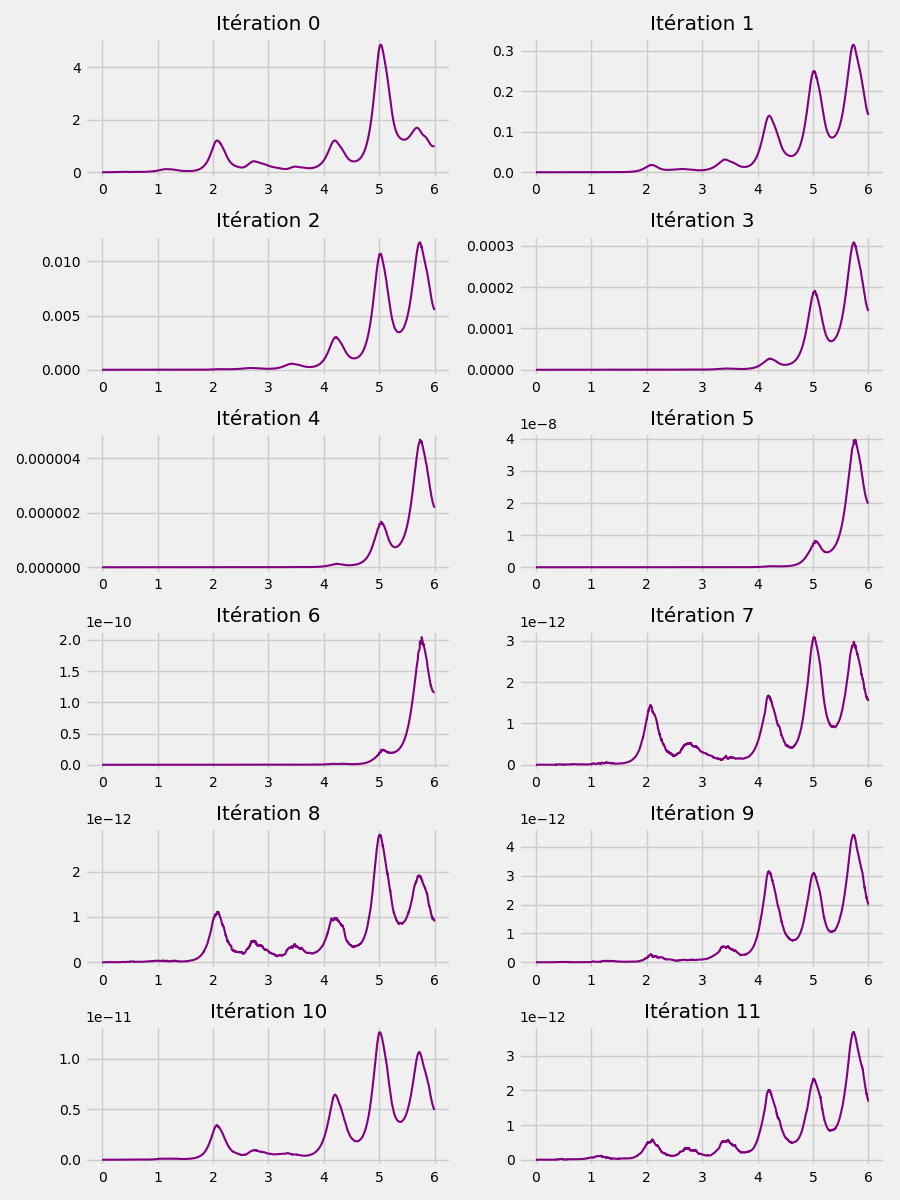

In [34]:
Erreur=np.zeros((K,NG*NF+1),float)
plt.figure(figsize=(9,K))
for k in range(K) :
    plt.subplot(int(K/2),2,k+1)
    Erreur[k,:]=np.sqrt(err[k,:,0]**2+err[k,:,1]**2+err[k,:,2]**2)
    plt.plot(tt,Erreur[k,:],color='purple',label=f"Erreur de l'algorithme Pararéel à l'itération {k}")
    plt.title(f"Itération {k}")
    plt.tight_layout()

On remarque donc bien que l'erreur diminue beaucoup lors des premières itérations sur cet exemple. Elle se stabilise ensuite aux alentours de $10^{-11}$, $10^{-12}$.

On fait également le test en changeant la méthode grossière : on prend maintenant `EulerExplicite` en augmentant le nombre de sous-intervalles grossiers.

In [35]:
K=40
y0=np.array([5,-5,20])
T=6
NF,NG,Fin,Grossier=40,512,RK4,EulerExplicite
tt,Fn,Gn,FN=parareal(fLorenz,Fin,NF,Grossier,NG,T,y0,K)
tt,solRK4=RK4(fLorenz,0,T,y0,NF*NG)
solRK4=np.array(solRK4)
xRK4,yRK4,zRK4=solRK4[:,0],solRK4[:,1],solRK4[:,2]

<IPython.core.display.Javascript object>


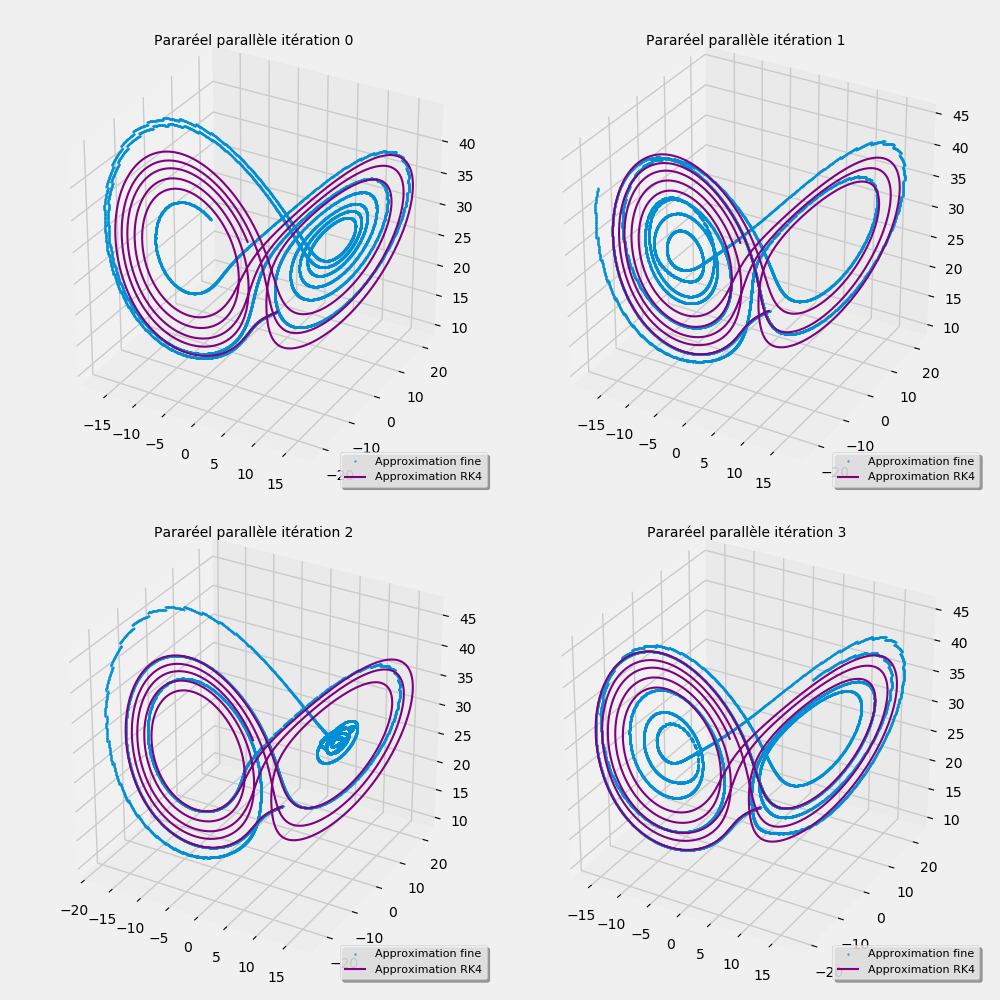

<IPython.core.display.Javascript object>


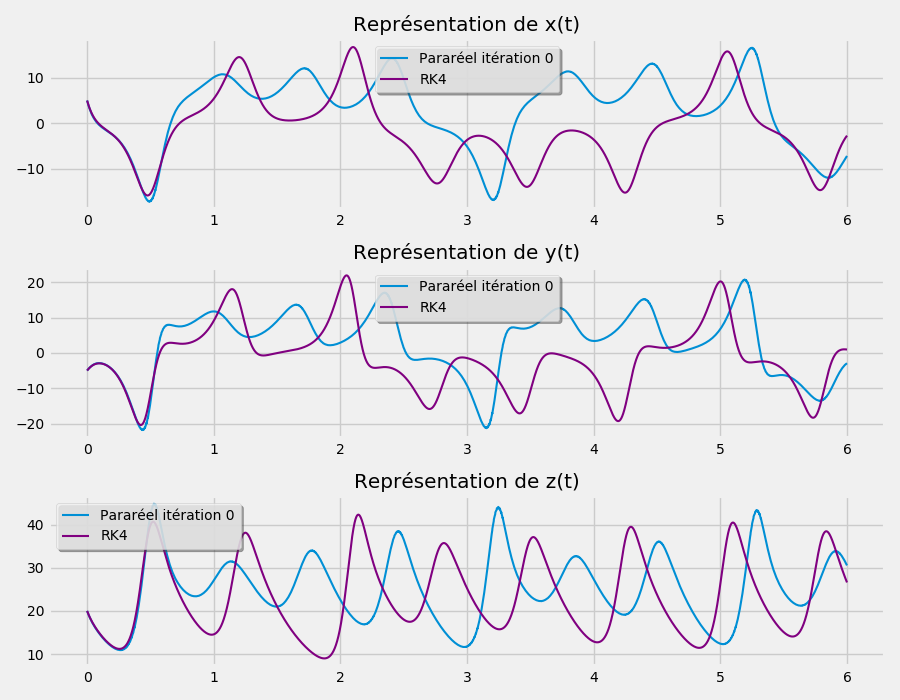

<IPython.core.display.Javascript object>


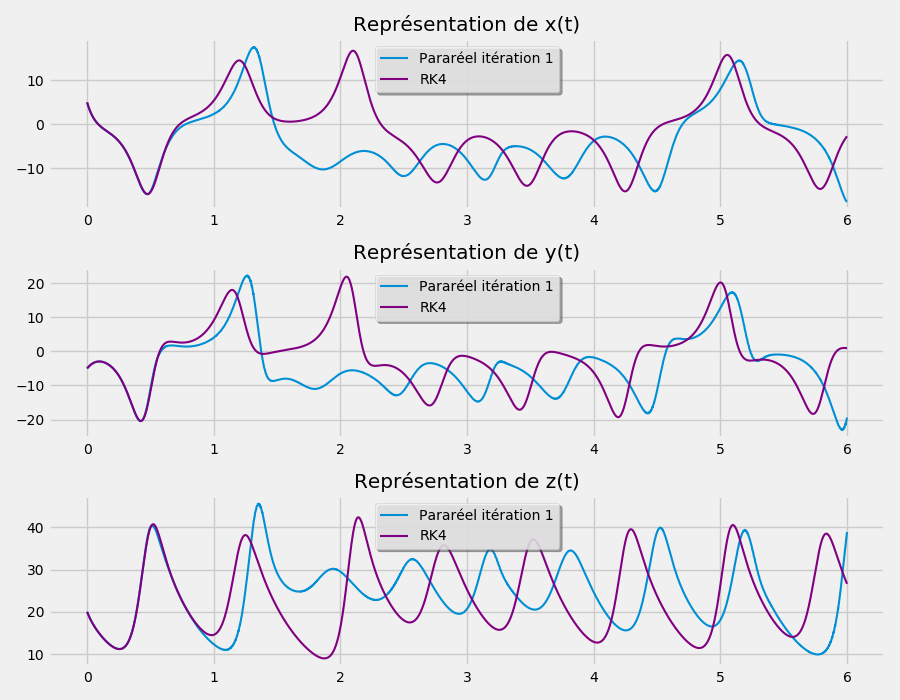

<IPython.core.display.Javascript object>


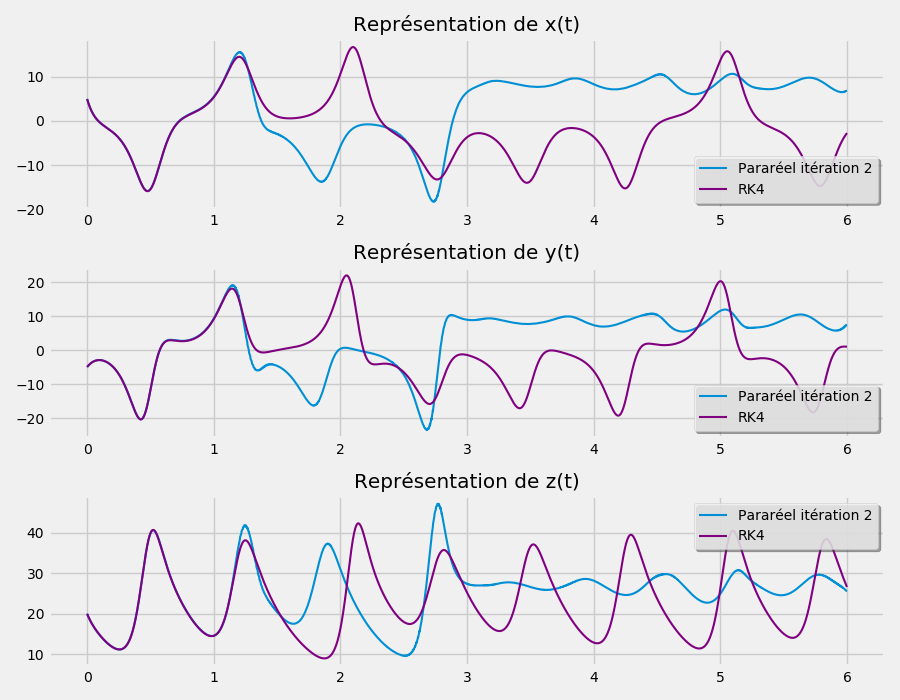

<IPython.core.display.Javascript object>


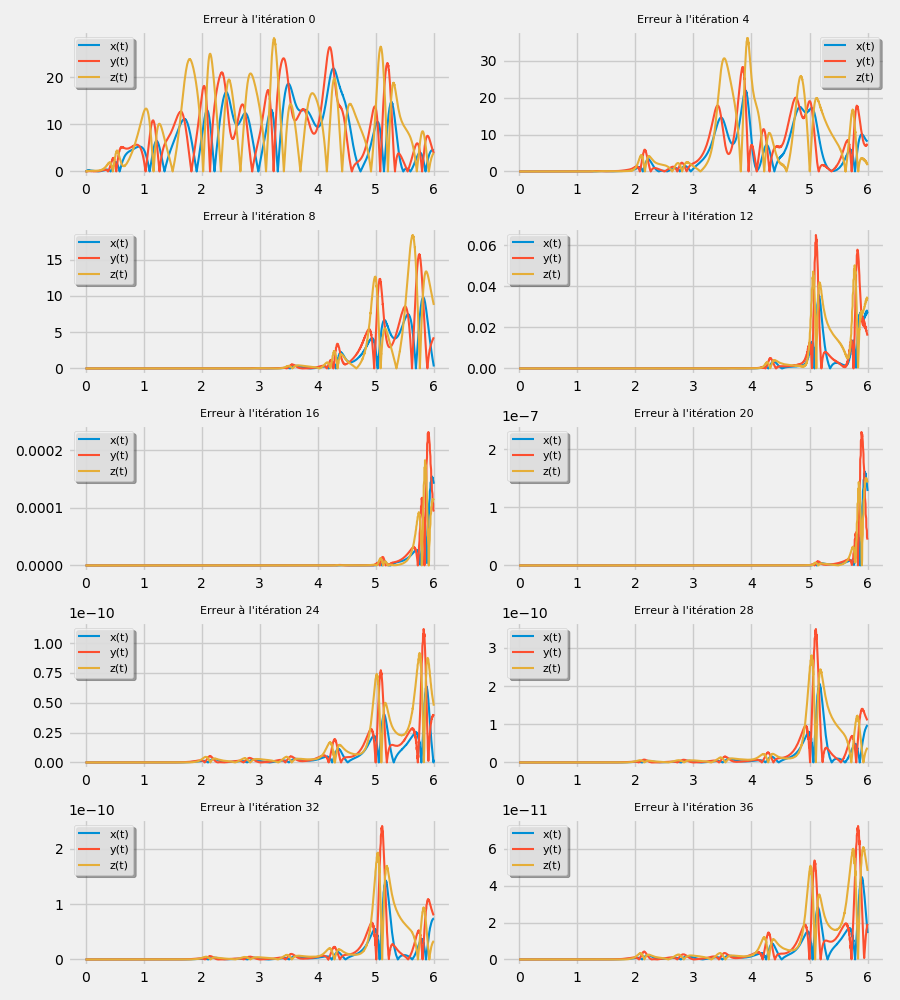

<IPython.core.display.Javascript object>


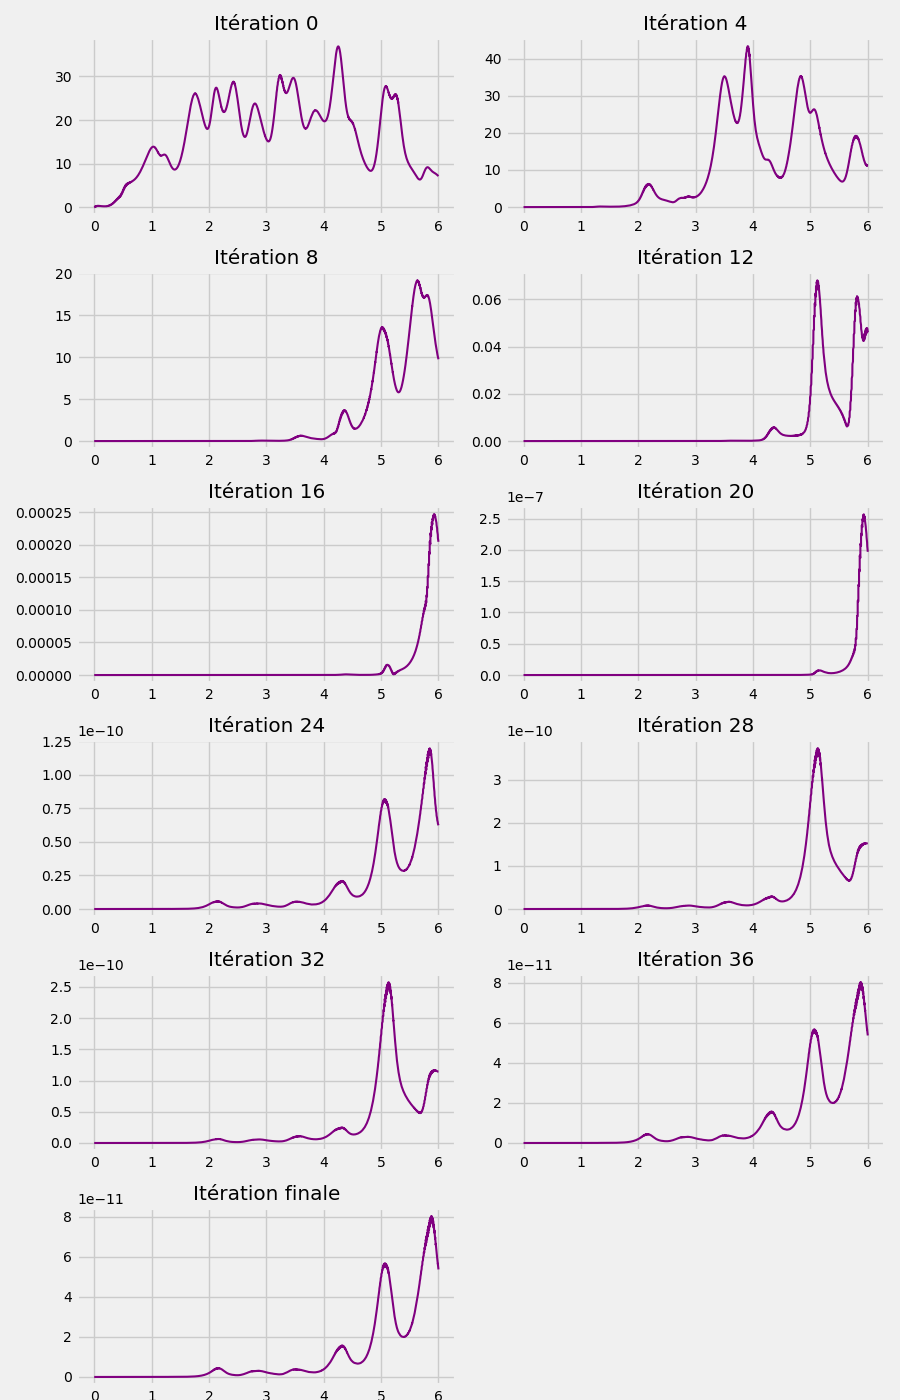

In [36]:
fig = plt.figure(figsize=(10,10))
for k in range(0,4) : 

    ax = fig.add_subplot(2, 2, k+1, projection='3d')
    ax.plot(FN[k,:,0],FN[k,:,1],FN[k,:,2],'.',ms=1,label="Approximation fine")
    ax.plot(xRK4[:],yRK4[:],zRK4[:],'-',color='purple',label="Approximation RK4")
    ax.legend(loc='lower right',fontsize=8)
    plt.title(f'Pararéel parallèle itération {k}',fontsize=10)
    plt.tight_layout()
plt.show()
fn=np.zeros((K,NF*NG+1,3),float)
for k in range(K):
    fn[k,:-1,:]=np.concatenate(Fn[k,:,:-1,:],axis=0)
    fn[k,-1,:]=Fn[k,-1,-1,:]
for k in range(0,3) :
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(tt,fn[k,:,0],label=f'Pararéel itération {k}')
    plt.plot(tt,xRK4[:],color='purple',label="RK4")
    plt.title("Représentation de x(t)")
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(tt,fn[k,:,1],label=f'Pararéel itération {k}')
    plt.plot(tt,yRK4[:],color='purple',label="RK4")
    plt.title("Représentation de y(t)")
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(tt,fn[k,:,2],label=f'Pararéel itération {k}')
    plt.plot(tt,zRK4[:],color='purple',label="RK4")
    plt.title("Représentation de z(t)")
    plt.legend()
    plt.tight_layout()
err=np.zeros((K,NG*NF+1,3),float)
plt.figure(figsize=(9,K/4))
i=0
for k in range(0,K,4) :
    i+=1
    err[k,:,0],err[k,:,1],err[k,:,2]=np.abs(fn[k,:,0]-xRK4[:]),np.abs(fn[k,:,1]-yRK4[:]),np.abs(fn[k,:,2]-zRK4[:])
    plt.subplot(int(K/8),2,i)
    plt.plot(tt,err[k,:,0],label=f'x(t)')
    plt.plot(tt,err[k,:,1],label=f'y(t)')
    plt.plot(tt,err[k,:,2],label=f'z(t)')
    plt.legend(fontsize=8)
    plt.title(f"Erreur à l'itération {k}",fontsize=8)
    plt.tight_layout()
Erreur=np.zeros((K,NG*NF+1),float)
plt.figure(figsize=(9,K/4+4))
i=0
for k in range(0,K,4) :
    i+=1
    plt.subplot(int(K/8)+1,2,i)
    Erreur[k,:]=np.sqrt(err[k,:,0]**2+err[k,:,1]**2+err[k,:,2]**2)
    plt.plot(tt,Erreur[k,:],color='purple',label=f"Erreur de l'algorithme Pararéel à l'itération {k}")
    plt.title(f"Itération {k}")
    plt.tight_layout()
plt.subplot(int(K/8)+1,2,11)
Erreur[-1,:]=np.sqrt(err[-1,:,0]**2+err[-1,:,1]**2+err[-1,:,2]**2)
plt.plot(tt,Erreur[k,:],color='purple',label=f"Erreur de l'algorithme Pararéel à l'itération finale")
plt.title(f"Itération finale")
plt.show()

**Il est donc réellement important de choisir une méthode grossière adaptée au problème. Sinon, le nombre d'itérations nécessaires à l'obtention du précision raisonnable augmente drastiquement. Sur cet exemple, on a diminué les pas de temps utilisés et on obtient après 40 itérations une précision approximativement aussi satisfaisante que sur l'exemple précédent avec 12 itérations.**

On cherche maintenant à visualiser l'intérêt d'un algorithme parallèle par rapport à une méthode séquentielle, en termes de temps. Pour cela on va utiliser l'algorithme Pararéel de manière séquentielle puis parallèle en faisant augmenter le nombre de points calculés, avec une itération de l'algorithme. On utilisera finalement `RK4` afin de comparer et de visualiser le speedup. On représentera alors le temps de calcul en fonction du nombre de subdivisions grossières. 

**Remarques :**
1. lorsque l'on augmente le nombre de subdivisions grossières, on diminue le pas de temps fin,
1. le but principal ici est de comparer l'algorithme Pararéel appliqué en parallèle et la méthode fine séquentielle,

1. **la compilation des prochaines cellules peut prendre un peu de temps.**

In [37]:
y0=np.array([5,-5,20]) # on donne la condition initiale
T= 4# on choisit le temps final
temps_seq,temps_para,temps_para2,temps_RK=[],[],[],[]
NF=1000
for n in range(16,321,16) : 
    start_time=time.time()
    parareal(fLorenz,RK4,NF,EulerExplicite,n,T,y0,1)
    temps_para.append(time.time()-start_time)
for n in range(16,321,16) : 
    start_time=time.time()
    parareal_seq(fLorenz,RK4,NF,EulerExplicite,n,T,y0,1)
    temps_seq.append(time.time()-start_time)
for n in range(16,321,16) : 
    start_time=time.time()
    RK4(fLorenz,0,T,y0,n*NF)
    temps_RK.append(time.time()-start_time)

<IPython.core.display.Javascript object>


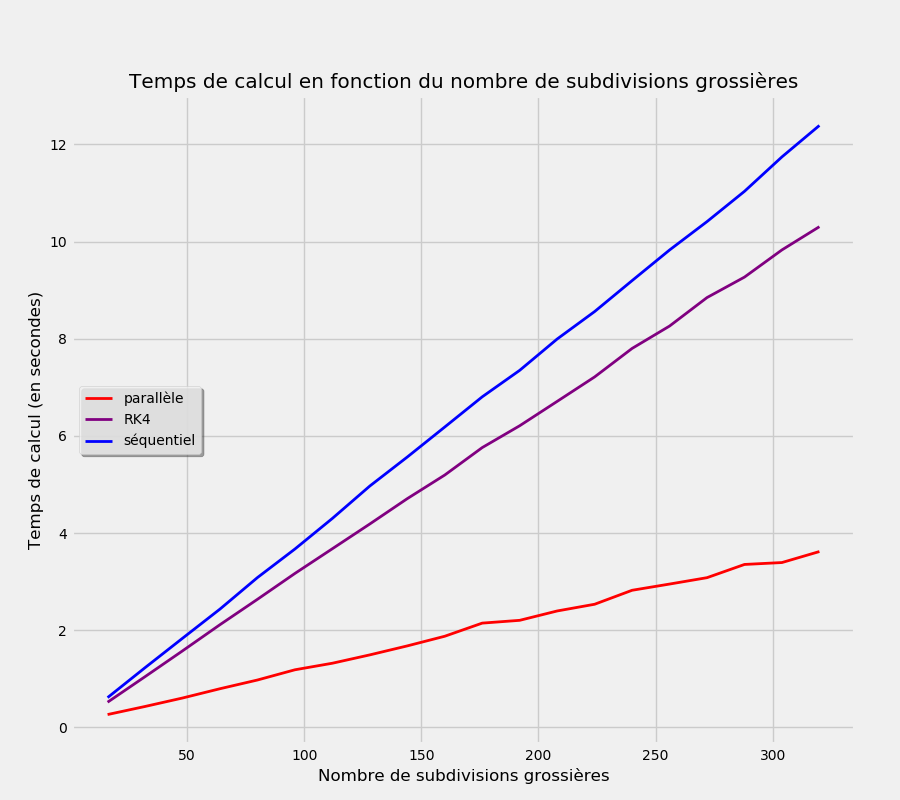

In [38]:
plt.figure(figsize=(9,8))
n=[i for i in range(16,321,16)]
plt.plot(n,temps_para,'-',linewidth=2,color='red',label="parallèle")
plt.plot(n,temps_RK,'-',linewidth=2,color='purple',label="RK4")
plt.plot(n,temps_seq,'-',linewidth=2,color='blue',label="séquentiel")
plt.xlabel("Nombre de subdivisions grossières")
plt.ylabel("Temps de calcul (en secondes)")
plt.title("Temps de calcul en fonction du nombre de subdivisions grossières")
plt.legend(loc="center left")
plt.show()

<IPython.core.display.Javascript object>


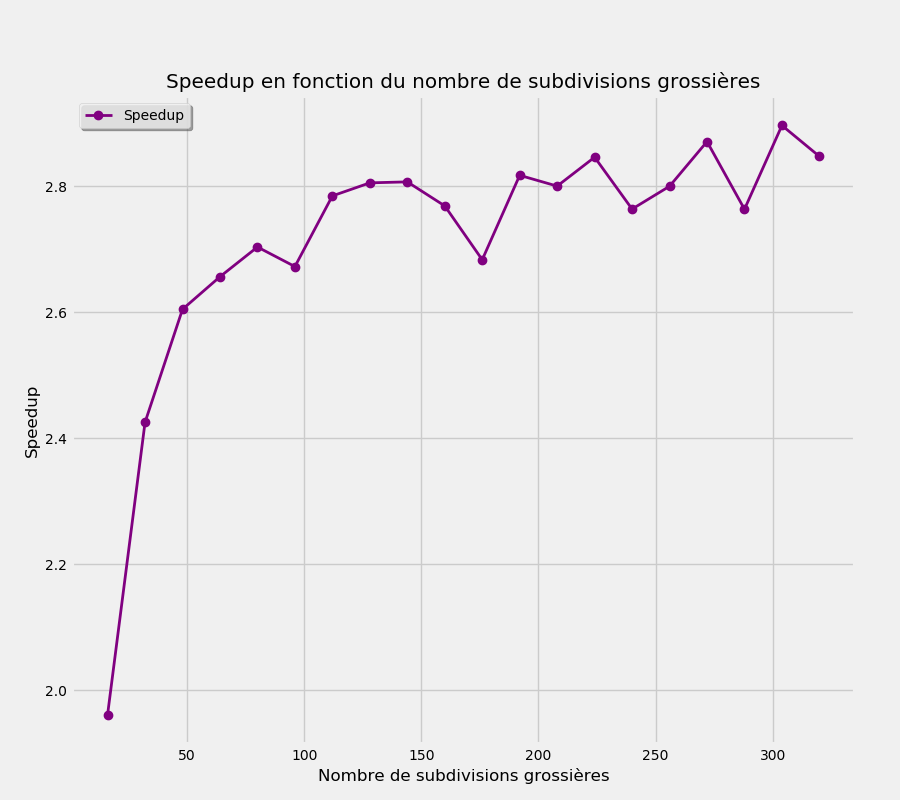

In [39]:
plt.figure(figsize=(9,8))
s=[temps_RK[i]/temps_para[i] for i in range(len(temps_RK))]
n=[i for i in range(16,321,16)]
plt.plot(n,s,'o-',linewidth=2,color='purple',label="Speedup")
plt.xlabel("Nombre de subdivisions grossières")
plt.ylabel("Speedup")
plt.title("Speedup en fonction du nombre de subdivisions grossières")
plt.legend(loc="best")
plt.show()

On souhaite également visualiser le speedup en fonction du nombre de coeurs utilisés. On choisit d'utiliser le même exemple avec $NF=1000$ et $NG=64$ et on utilise la méthode `parareal` en indiquant le nombre maximal de processeurs.

In [40]:
y0=np.array([5,-5,20]) # on donne la condition initiale
T=4 # on choisit le temps final
NG=64
NF=1000
nb_processors,temps,tempsrk=16,[],[]
startrk=time.time()
RK4(fLorenz,0,T,y0,NG*NF)
tempsrk=time.time()-startrk
for n in range(1,nb_processors+1) : 
    start_time=time.time()
    parareal(fLorenz,RK4,NF,EulerExplicite,NG,T,y0,1,n)
    temps.append(time.time()-start_time)

<IPython.core.display.Javascript object>


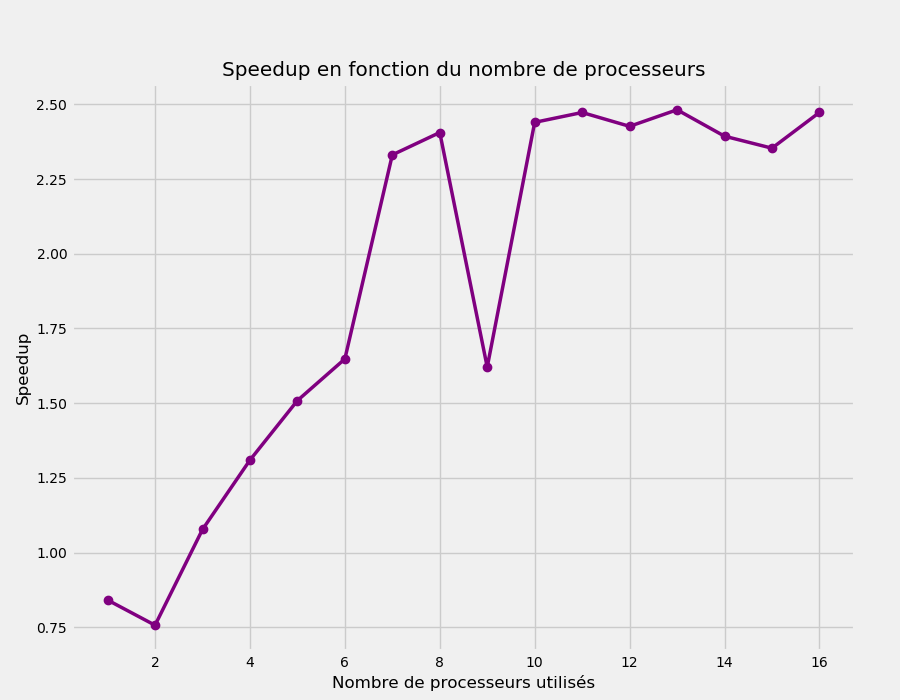

In [41]:
plt.figure()
speedup=[tempsrk/temps[i] for i in range(nb_processors)]
plt.plot([i for  i in range(1,nb_processors+1)],speedup,'o-',linewidth=2.5,color='purple')
plt.xlabel("Nombre de processeurs utilisés")
plt.ylabel("Speedup")
plt.title("Speedup en fonction du nombre de processeurs")
plt.show()

Cette visualisation, bien que peu précise étant donné qu'elle est obtenue avec peu de processeurs, permet tout de même de voir l'intérêt d'augmenter le nombre de processeurs utilisés.

### Le système solaire externe <a name="3.3.2"></a>

On s'intéresse finalement à la représentation graphique d'un problème introduit dans la partie théorique : les trajectoires des planètes du système solaire externe. Pour cela, on a récupéré les données des différentes planètes pour obtenir leur masse et leur position initiale.

On utilise alors un repère héliocentrique et des unités astronomiques ainsi que le système différentiel : $$ \ddot{Y}_i = G \sum_{j \neq i} m_j \dfrac{Y_j - Y_i}{\|Y_j-Y_i\|} \Longleftrightarrow \begin{cases}  \dot{Y}_i = V_i \\ \dot{V}_i = G \displaystyle\sum_{j \neq i} m_j \dfrac{x_j - x_i}{\|Y_j-Y_i\|} . \end{cases} $$

In [42]:
Soleil=np.array([1.00000597682,0,0,0,0,0,0])
Neptune=np.array([0.0000517759138449,11.4707666,-25.7294829,-10.8169456,0.00288930,0.00114527,0.00039677])
Jupiter=np.array([0.000954786104043,-3.5023653,-3.8169847,-1.5507963,0.00565429,-0.00412490,-0.00190589])
Saturn=np.array([0.000285583733151,9.0755314,-3.0458353,-1.6483708,0.00168318,0.00483525,0.00192462])
Uranus=np.array([0.0000437273164546,8.3101420,-16.2901086,-7.2521278,0.00354178,0.00137102,0.00055029])
Pluto=np.array([ 1/(1.3*10**8),-15.5387357,-25.2225594,-3.1902382,0.00276725,-0.00170702,-0.00136504])

Y0=np.array([Soleil,Neptune,Jupiter,Saturn,Uranus,Pluto])
Systeme_ext=["Soleil","Neptune","Jupiter","Saturne","Uranus","Pluton"]

def f(X,t) :
    G=2.995912208286*10**(-4)
    x,y,z,w,t,p=X
    xdot=w
    ydot=t
    zdot=p
    wdot,tdot,pdot=0,0,0
    for i in range(0,len(Y0)) :
        if(i!=j) :
            r=sqrt((Y0[i,1]-x)**2+(Y0[i,2]-y)**2+(Y0[i,3]-z)**2)
            wdot+=G*Y0[i,0]*(Y0[i,1]-x)/r**3
            tdot+=G*Y0[i,0]*(Y0[i,2]-y)/r**3
            pdot+=G*Y0[i,0]*(Y0[i,3]-z)/r**3
    return np.array([xdot,ydot,zdot,wdot,tdot,pdot])



<IPython.core.display.Javascript object>


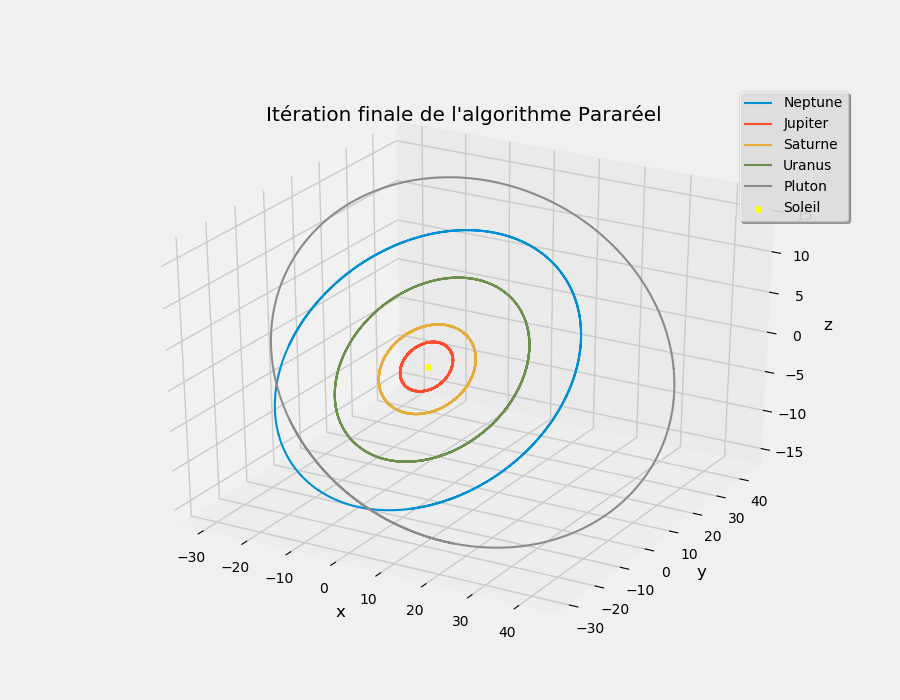

In [43]:
fig=plt.figure() # initialisation  de la figure
fig=fig.gca(projection='3d') # graphiqe 3d
fig.set_xlabel('x')
fig.set_ylabel('y')
fig.set_zlabel('z')
fig.scatter3D(0,0,0,color='yellow',label="Soleil")

for j in range(1,len(Y0)) : 
    tt,Fn,Gn,sol=parareal(f,RK4,10,RK4,400,10**5,Y0[j,1:],4)
    x,y,z,w,t,p=sol[-1,:,0],sol[-1,:,1],sol[-1,:,2],sol[-1,:,3],sol[-1,:,4],sol[-1,:,5]
    fig.plot(x,y,z,label=Systeme_ext[j])
    
fig.legend()
plt.title(f"Itération finale de l'algorithme Pararéel")
plt.show()

# Exemples d'application en biologie et en épidémiologie <a name="3.4"></a>

On présente maintenant deux exemples d'applications des méthodes numériques dans d'autres domaines scientifiques : la biologie et l'épidémiologie.

On définit ici la fonction logistique. Cette fonction est utilisée notamment en biologie dans l'étude des populations afin de modéliser la croissance des populations, par exemple la population d'éléphants. 

Cette fonction est définie par : 

$$\begin{cases} \dot{y}(t)=r y(t)\left(1-\frac{y(t)}{K}\right) \\ y(t_0)=y_0. \end{cases}$$

In [44]:
def fLogistique(Y,t):
    r,K=0.15,7500
    y=Y
    ydot=r*y*(1-y/K)
    return ydot

<IPython.core.display.Javascript object>


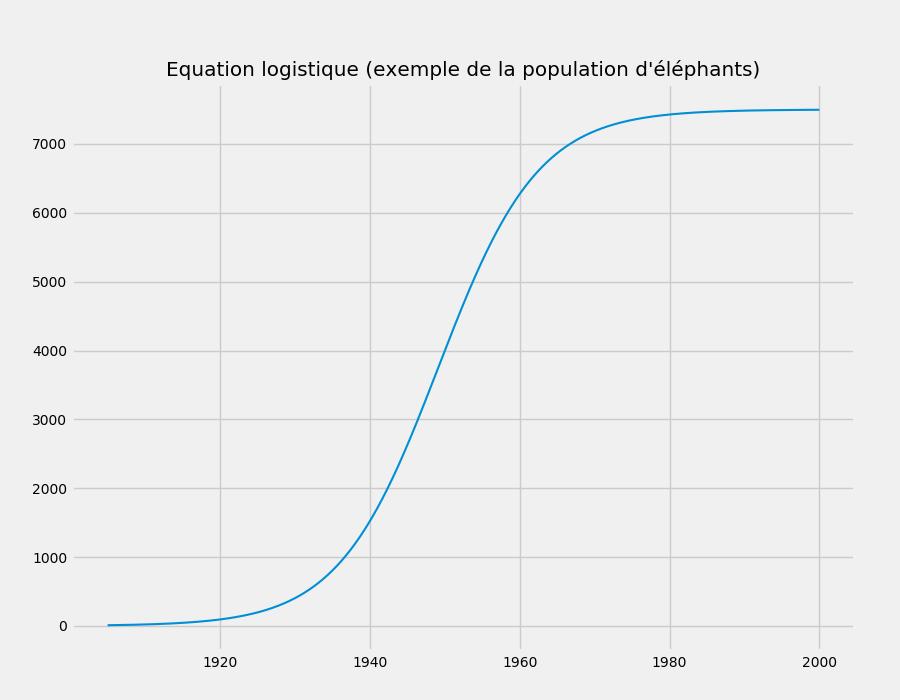

In [45]:
T,Y=RK4(fLogistique,1905,2000,np.array([10]),4000)
Y=np.array(Y)
plt.figure()
plt.plot(T,Y[:,0])
plt.title("Equation logistique (exemple de la population d'éléphants)")
plt.show()

On implémente ensuite le modèle SIR (modèle épidémiologique). Ce modèle correspond à une épidémie avec un taux d'incidence $\beta$ et une durée de maladie $\lambda$. On considère les conditions initiales sur les parts de la population initiale :
1. Population infectée : $I(0)=0.3$.
1. Population saine : $S(0)=0.7$.
1. Population rétablie : $R(0)=0$.

On définit alors : 

$$\begin{cases} \dot{I}(t)=\beta I(t)S(t)-\frac{I(t)}{\lambda} \\ \dot{S}(t) = -\beta I(t)S(t) \\ \dot{R}(t)=\frac{I(t)}{\lambda}. \end{cases}$$

In [46]:
def fSIR(Y,t) :
    beta,lambd=0.5,10
    I,S,R=Y
    Idot=beta*I*S-I/lambd
    Sdot=-beta*I*S
    Rdot=I/lambd
    return np.array([Idot,Sdot,Rdot])

<IPython.core.display.Javascript object>


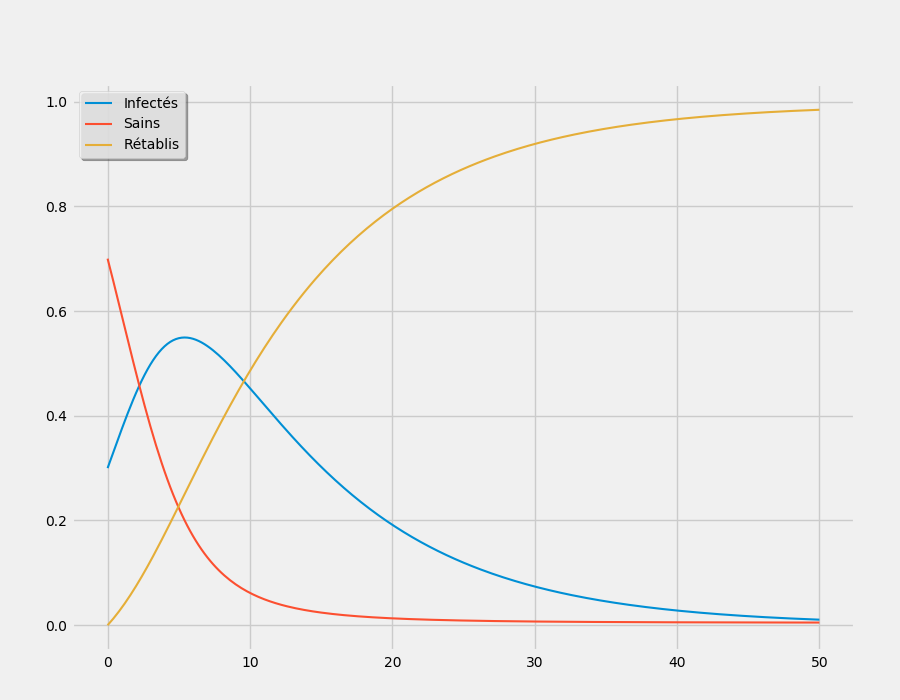

In [47]:
tt,sol=RK4(fSIR,0,50,np.array([0.3,0.7,0]),250)
sol=np.array(sol)
plt.figure()
plt.plot(tt,sol[:,0],label="Infectés")
plt.plot(tt,sol[:,1],label="Sains")
plt.plot(tt,sol[:,2],label="Rétablis")
plt.legend()
plt.show()

# Le $\theta$-schéma pour l'équation de la chaleur <a name="3.5"></a>

On s'intérese maintenant à un exemple d'équation aux dérivées partielles, afin d'introduire une extension à ce projet.

On définit tout d'abord une méthode qui nous permettra de construire les matrices que l'on utilisera dans le $\theta$-schéma.

In [48]:
def Matrices(n,c1,c2):
    M = np.zeros((n+1,n+1),float)
    M[0,0] = M[-1,-1] = 1
    for i in range(1,n):
        M[i,i]= c2
        M[i,i-1] = M[i,i+1]= -c1
    return M

On considère ici l'équation : 
$$\begin{cases}
\frac{\partial u}{\partial t}- \frac{\partial^2 u}{\partial x^2} =0 & (x,t) \in ]0,X[ \times ]0,T[ \\
u(x,0)=u_0(x) & x \in ]0,X[ \\
u(0,t)=u(X,t)=0  & t \in ]0,T[.
\end{cases}$$

In [49]:
def HeatEquationTheta(L,dx,tf,dt,theta,Tinit):
    #Tinit=np.array([Tbarre,Text])
    Nt=int(tf/dt)
    Nx=int(L/dx)
    c=dt/(dx*dx) 
    
    esp = np.linspace(0.0,L,Nx+1)
    temps = np.linspace(0.0, tf,Nt+1)
    T = np.zeros((Nt+1,Nx+1),float) # matrice des solutuions
    if((theta >= 1/2) or (c<=1/(2*(1-2*theta)))):
        Impl = Matrices(Nx,theta*c,1 + 2*theta*c) #schéma implicite
        Expl = Matrices(Nx,-(1-theta)*c, 1 - 2*(1-theta)*c) #schéma explicite

        T[0,:] = Tinit[0]*np.ones(Nx+1,float) # on donne les différentes conditions initiales
        T[:,0]=T[:,-1]= Tinit[1]*np.ones(Nt+1,float)
    
        for t in range(0,Nt):
            T[t+1,:] = np.linalg.solve(Impl,np.dot(Expl,T[t,:])) #on résout le système
    else :
        print("Schéma instable")
    return T,esp,temps

<IPython.core.display.Javascript object>


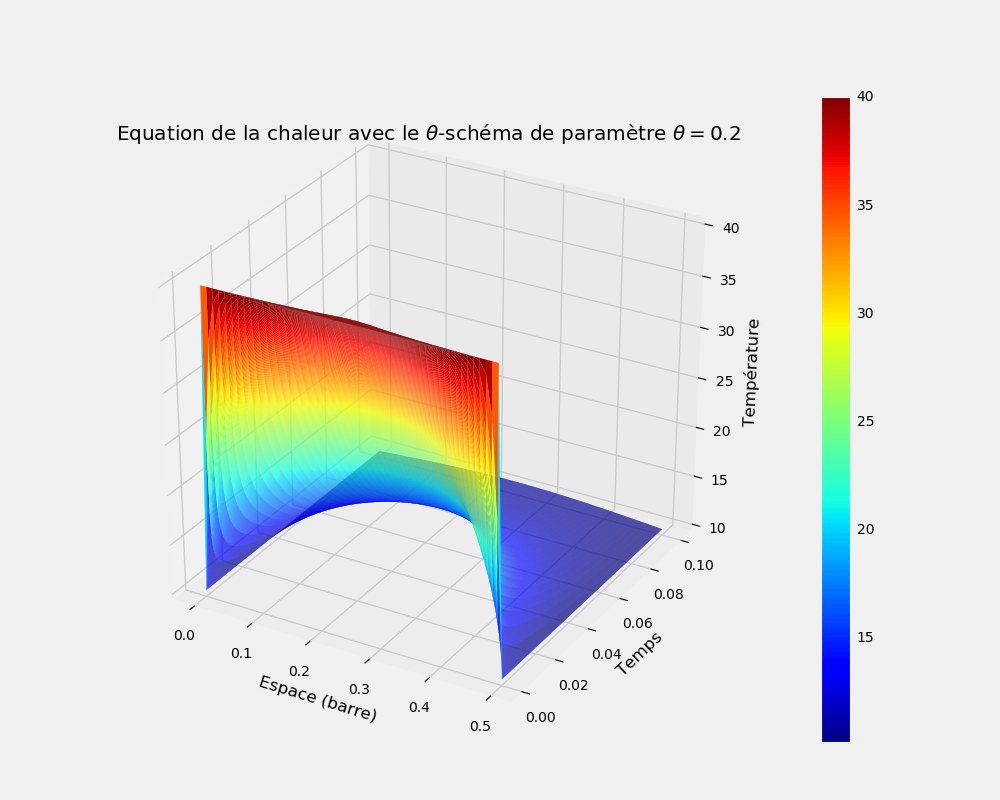

In [50]:
L,dx,tf,dt,theta,Tinit=0.5,1.0e-2,0.1,1.0e-5,0.2,np.array([40.0,10.0])
T,Esp,Temps=HeatEquationTheta(L,dx,tf,dt,theta,Tinit)

MX,MT = np.meshgrid(Esp,Temps)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_xlabel('Espace (barre)')
ax.set_ylabel('Temps')
ax.set_zlabel('Température')

norm = colors.Normalize(Tinit[1],Tinit[0])
p = ax.plot_surface(MX,MT,T,cstride=1,linewidth=0,cmap='jet')
plt.title(fr"Equation de la chaleur avec le $\theta$-schéma de paramètre $\theta= ${theta}")
cb = fig.colorbar(p)


**Une extension à ce projet et notamment à ce notebook serait donc de résoudre cette équation, et plus généralement les équations aux dérivées partielles à l'aide d'un algorithme parallèle.**

**En effet, la résolution de ce type d'équations peut nécessiter beaucoup de temps, cela pourrait donc être intéressant d'utiliser la parallélisation afin de gagner du temps.**

# Bonus : quelques animations <a name="4"></a>

On réalise quelques animations afin de voir tout d'abord les étapes du tracé des attracteurs de Lorenz avec la méthode `RK4` puis, les effets des itérations de l'algorithme Pararéel.

Tout d'abord une animation du tracé des attracteurs de Lorenz obtenu avec la méthode de Runge-Kutta d'ordre 4, avec 4001 points tracés.

In [51]:
HTML('<center><iframe width="800" height="500" src="https://www.youtube.com/embed/4pLWIzoqIQw" frameborder="0" allow="accelerometer; autoplay" allowfullscreen></iframe></center>')

On veut maintenant visualiser les résultats rapidement probants de l'algorithme Pararéel sur l'exemple de l'équation $\dot{y}(t)=\cos(t)$.

In [52]:
def f(Y,t):
    return np.cos(t)

K=3
y0=np.array([0])
T=10
NF,NG,Fin,Grossier=20,20,EulerExplicite,EulerExplicite
tt,Fn,Gn,FN=parareal(f,Fin,NF,Grossier,NG,T,y0,K)

In [53]:
HTML('<center><iframe width="800" height="500" src="https://www.youtube.com/embed/MWiAx88eBfg" frameborder="0" allow="accelerometer; autoplay" allowfullscreen></iframe></center>')

Ensuite, on décide de faire une nouvelle animation pour visualiser les résultats des itérations de l'algorithme Pararéel. On définit alors la fonction : $$\begin{cases} \dot{y}(t)=\sin(t \times y), \ t \in [0,20], \\ y(0)=17. \end{cases} $$

In [54]:
def f(Y,t):
    y=Y
    return np.sin(y*t)

K=11
y0=np.array([17])
T=20
NF,NG,Fin,Grossier=500,10,EulerExplicite,EulerExplicite
tt,Fn,Gn,FN=parareal(f,Fin,NF,Grossier,NG,T,y0,K)

On réalise alors une animation à partir des résultats obtenus.

In [55]:
HTML('<center><iframe width="800" height="500" src="https://www.youtube.com/embed/6ElUykiF8OM" frameborder="0" allow="accelerometer; autoplay" allowfullscreen></iframe></center>')

On choisit maintenant de faire une représentation des itérations de l'algorithme Pararéel appliqué aux équations de Lorenz, avec `EulerExplicite`  (peu adapté au problème) et `RK4`.

In [56]:
K=19
y0=np.array([5,-5,20])
T=5
NF,NG,Fin,Grossier=20,512,RK4,EulerExplicite
tt,Fn,Gn,FN=parareal(fLorenz,Fin,NF,Grossier,NG,T,y0,K)

In [57]:
HTML('<center><iframe width="800" height="500" src="https://www.youtube.com/embed/8c9B3Tzaa4c" frameborder="0" allow="accelerometer; autoplay" allowfullscreen></iframe></center>')

On réalise enfin 20 itérations de l'algorithme sur un temps plus long afin de voir les effets des itérations en utilisant `RK4` avec $NG=256$ et `RK4` avec $NF=100$. 

In [58]:
K=20
y0=np.array([5,-5,20])
T=20
NF,NG,Fin,Grossier=100,256,RK4,RK4
tt,Fn,Gn,FN=parareal(fLorenz,Fin,NF,Grossier,NG,T,y0,K)

In [59]:
HTML('<center><iframe width="800" height="500" src="https://www.youtube.com/embed/X3zG7TeYoJY" frameborder="0" allow="accelerometer; autoplay" allowfullscreen></iframe></center>')